# Broadband Intensity Tomography

### This notebook implements a forecast for a Broadband Intensity Tomographic Survey with a future all sky UV-optical survey. This is an extension of the measurements reported in https://arxiv.org/abs/1810.00885

### Section 1: Import Statements, Physical Constants, and Reading Filter Transmission Curves

In [1]:
# General Utilities

import numpy as np
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt

# Emcee sampling, multiprocessing and analysis
import time
import corner
from multiprocess import Pool

# define background cosmology using the colossus package
# Set to Planck 2018 best fit

from colossus.cosmology import cosmology

cosmo = cosmology.setCosmology('planck18')

#physical constants 

speed_of_light = 3*10**18 #in angstroms/s

#sampler

import emcee

In [2]:
# Display cosmology

print(cosmo)

Cosmology "planck18" 
    flat = True, Om0 = 0.3111, Ode0 = 0.6888, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.8102, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [3]:
# Read in filter curves and interpolate in wavelength

class ThroughputCurve:
    def __init__(self, dataframe):
        self.waves = dataframe[0]
        self.throughput = dataframe[1]
        
#path = "/rhome/bscot002/bigdata/passbands/"
path = "passbands/"
        
castor_names = ['passband_castor_uv.csv', 
                'passband_castor_uv_dark.csv', 
                'passband_castor_u.csv',
                'passband_castor_u_wide.csv', 
                'passband_castor_g.csv']

galex_names = ['galex1500.res.txt', 
               'galex2500.res.txt']

throughput_curve_names = castor_names + galex_names

filter_waves = ThroughputCurve(pd.read_csv(path+castor_names[1], 
                                                      delim_whitespace=True, skiprows=0, header=None)).waves

throughputs = np.zeros((5, 1001))
for i,f in enumerate(castor_names): 
       throughputs[i,:] = ThroughputCurve(pd.read_csv(path+f, 
                                                      delim_whitespace=True, skiprows=0, header=None)).throughput

castor_uv_throughput = throughputs[0,:]
castor_uv_waves = filter_waves

castor_uv = interpolate.interp1d(np.array(castor_uv_waves)*10000, np.array(castor_uv_throughput), bounds_error = False, fill_value = 0)
castor_uv_dark = interpolate.interp1d(np.array(filter_waves)*10000, np.array(throughputs[1,:]), bounds_error = False, fill_value = 0)
castor_u = interpolate.interp1d(np.array(filter_waves)*10000, np.array(throughputs[2,:]), bounds_error = False, fill_value = 0)
castor_u_wide = interpolate.interp1d(np.array(filter_waves)*10000, np.array(throughputs[3,:]), bounds_error = False, fill_value = 0)
castor_g = interpolate.interp1d(np.array(filter_waves)*10000, np.array(throughputs[4,:]), bounds_error = False, fill_value = 0)


throughputs_galex_fuv = ThroughputCurve(pd.read_csv(path+galex_names[0], 
                                                      delim_whitespace=True, skiprows=0, header=None)).throughput
        
filter_waves_fuv = ThroughputCurve(pd.read_csv(path+galex_names[0], 
                                                      delim_whitespace=True, skiprows=0, header=None)).waves

galex_fuv = interpolate.interp1d(np.array(filter_waves_fuv), np.array(throughputs_galex_fuv), bounds_error = False, fill_value = 0)

throughputs_galex_nuv = ThroughputCurve(pd.read_csv(path+galex_names[1], 
                                                      delim_whitespace=True, skiprows=0, header=None)).throughput
        
filter_waves_nuv = ThroughputCurve(pd.read_csv(path+galex_names[1], 
                                                      delim_whitespace=True, skiprows=0, header=None)).waves

galex_nuv = interpolate.interp1d(np.array(filter_waves_nuv), np.array(throughputs_galex_nuv), bounds_error = False, fill_value = 0)

filters = np.array([castor_uv, castor_uv_dark, castor_u, castor_u_wide, castor_g, galex_fuv, galex_nuv])

### Section 2: Define the Emissivity Model

These parameters are needed in the global name-space. Some are in the global name space for convenience, others are physical constants.

#### Define Parameter Vector to be Varied in MCMC 
Initially set to fiducial values

In [4]:
nu1500 = speed_of_light/1500
nu1216 = speed_of_light/1216
nu912 = speed_of_light/912


log_e1500z0_b1500z0 = 25.13 #note this degeneracy needs to be resolved 
gammae1500 = 2.06
alpha1500z0 = -0.08
Calpha1500 = 1.85
alpha1100z0 = -3.71
Calpha1100 = 0.50 
EWLyAz03 = -6.17
EWLyAz1 = 88.02
gammabnu = -0.86
gammabz = 0.79

#normalizations

b1500z0 = 0.32 #from "breaking the degeneracy section" --> follow up on this! 
e1500z0 = (10**(log_e1500z0_b1500z0))/b1500z0

#assumed values

alpha900 = -1.5
logfLyCz1 = -0.53 
logfLyCz2 = -0.84 

fLyCz1 = np.exp(logfLyCz1)
fLyCz2 = np.exp(logfLyCz2)


theta_1 =  log_e1500z0_b1500z0, gammae1500, alpha1500z0, Calpha1500, alpha1100z0, Calpha1100, EWLyAz03, EWLyAz1, gammabnu, gammabz, logfLyCz2, logfLyCz2
theta =  gammabnu, gammabz, log_e1500z0_b1500z0, gammae1500, alpha1500z0, Calpha1500, alpha1100z0, Calpha1100, EWLyAz1, logfLyCz2, logfLyCz2

### The following functions are used to define the emissivity model.
They should be evaluated in the emission rest frame at frequency nu, where the observed frequency $\nu = \nu_{obs}(1+z)$

In [5]:
def CLyC(logfLyCz2 = -0.84, logfLyCz1 = -0.53):
    """Returns the the Lyman-Continuum escape fraction evolutions with redshift 
    as a function of observed values at redshifts 1 and 2."""
    #switched log10 --> log
    return (logfLyCz2 - logfLyCz1)/np.log10((1+2)/(1+1))

# def logfLyC(z, CLyC, fLyCz2, fLyCz1):
#     return CLyC(fLyCz2, fLyCz1) * np.log10((1+z)/(1+1)) + np.log10(fLyCz2)

def logfLyC(z, logfLyCz2 = -0.84, logfLyCz1 = -0.53):
    """Returns the log of the Lyman-Continuum escape fraction evolutions with redshift 
    as a function of observed values at redshifts 1 and 2."""
    #switched log10 --> log
    return CLyC(logfLyCz2, logfLyCz1) * np.log10((1+z)/(1+1)) + logfLyCz2

#Lyman alpha parameters 

def CLyA(EWLyAz1 = 88.02, EWLyAz03 = -6.17):
    #switched log10 --> log
    return (EWLyAz1 - EWLyAz03)/np.log10((1+1)/(1+0.3))

def EWLyA(z, EWLyAz1 = 88.02, EWLyAz03 = -6.17):
    """Returns the Ly-alpha equivalent width as a function of redshift and normalized to the constraint at redshift 3."""
    #switched log10 --> log
    return CLyA(EWLyAz1, EWLyAz03) * np.log10((1+z)/(1+0.3)) + EWLyAz03

#emissivity normalizations and parameters 

def e1500(z, e1500z0 = (10**(log_e1500z0_b1500z0))/b1500z0, gammae1500 = 2.06):
    """Returns the emissivity at 1500 angstroms as a function of redshift in terms of the normalized value at redshift 0
    and an evolution parameter."""
    return e1500z0 * (1+z)**(gammae1500)

def alpha1500(z, Calpha1500 = 1.85, alpha1500z0 = -0.08):
    """
    Returns the power law parameter as a function of redshfit at 1500 angstroms, the continuum value 
    and the value normalized to redshift 0.
    """
    #switched log10 --> log
    return alpha1500z0 + Calpha1500*np.log10(1+z)

def alpha1100(z, Calpha1100 = 0.50, alpha1100z0 = -3.71):
    """
    Returns the power law parameter at 1100 angstroms as a function redshift, the continuum value 
    and the value normalized to redshift 0.
    """
    #switched log10 --> log
    return alpha1100z0 + Calpha1100*np.log10(1+z)

# def delta(nu):
#     """For a vector of frequencies, returns a value 1 at the frequency corresponding to 1216 angstroms and 0 elsewhere."""
#     condlist = [np.trunc(speed_of_light/nu) == 1216, speed_of_light/nu != 1216]
#     funclist = [1, 0]
#     return np.select(condlist, funclist)

## Plot the Parameter Functions in redshift 

Text(0.5, 0, 'z')

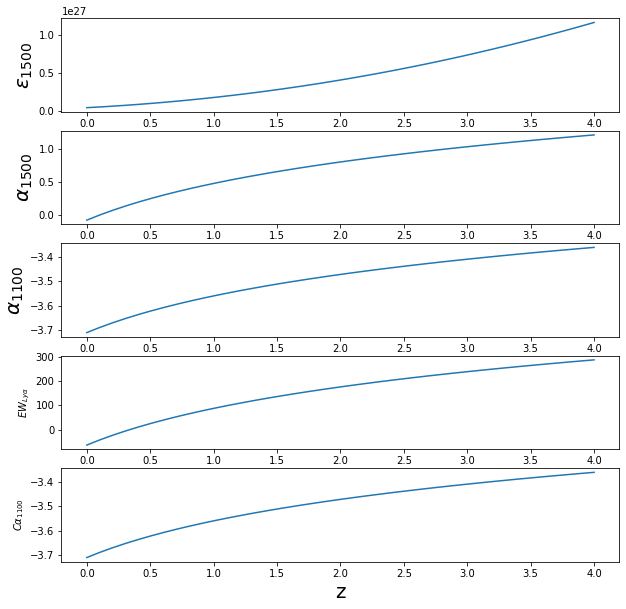

In [6]:
zs1 = np.linspace(0,4,40)

f = plt.figure(figsize=(10,10))

ax = f.add_subplot(5,1,1)
ax.plot(zs1, e1500(zs1))
ax.set_ylabel(r'$\epsilon_{1500}$', fontsize=20)

ax2 = f.add_subplot(5,1,2)
ax2.plot(zs1, alpha1500(zs1)) 
ax2.set_ylabel(r'$\alpha_{1500}$', fontsize=20)

ax3 = f.add_subplot(5, 1, 3)
ax3.plot(zs1, alpha1100(zs1))
ax3.set_ylabel(r'$\alpha_{1100}$', fontsize=20)

ax4 = f.add_subplot(5,1,4)
ax4.plot(zs1, EWLyA(zs1))
ax4.set_ylabel(r'$EW_{Ly\alpha}$')
ax4.set_xlabel('z', fontsize=20)

ax5 = f.add_subplot(5,1,5)
ax5.plot(zs1, alpha1100(zs1))
ax5.set_ylabel(r'$C\alpha_{1100}}$')
ax5.set_xlabel('z', fontsize=20)

## The Emissivity Model 

In [7]:
#hardcoded, evaluate in restframe, note, Ly-alpha is buggy. 
# use emissivity model code before with np.select and rounding to handle 1216 angstrom delta function

def emissivity_model(theta, z):
    """ 
    Returns the emissivity model for the rest frame frequency nu, at fixed uniform spacing in wavelength from 
    500-6000 angstroms. This wavelength range is hardcoded and covers the rest frame wavelength coverage of the CASTOR
    filters. 
    
    Note that this version does not include the functional form for the bias. 
    
    And this calls e1500(z) for the emissivity normalization and amplitude evolution
    
    Returns a vector of emissivities in (ergs s^-1 Hz^-1 Mpc^-3) for a set of input frequencies at a given redshift z. Here
    The emissivity model is defined in Chiang (2019) Appendix A, which is a piecewise power law (e proprtional to nu^alpha) with a lyman break and a lyman alpha delta function. 
    """
    
#     log_e1500z0_b1500z0, gammae1500, alpha1500z0, Calpha1500, alpha1100z0, Calpha1100, EWLyAz03, EWLyAz1, gammabnu, gammabz, fLyCz2, fLyCz2 = theta
    log_e1500z0_b1500z0, gammae1500, alpha1500z0, Calpha1500, alpha1100z0, Calpha1100, EWLyAz03, EWLyAz1, gammabnu, gammabz, logfLyCz2, logfLyCz2 = theta
    
    speed_of_light = 3*10**18 #in angstroms/s
    
    waves1216plus = np.linspace(1217, 6000, 6000-1216)
    nu1216plus = speed_of_light/waves1216plus
    
    #(nu1216plus/nu1500)**(gammabnu) * (1+z)**(gammabz) 
    emiss = e1500(z) * (nu1216plus/nu1500)**(alpha1500(z, Calpha1500, alpha1500z0))
    
    wavesbetween912and1216 = np.linspace(912, 1216, 1216-911)
    nubetween912and1216 = speed_of_light/wavesbetween912and1216
    
    #(nubetween912and1216/nu1500)**(gammabnu) * (1+z)**(gammabz) * 
    emiss2 = e1500(z) * (nu1216/nu1500)**(alpha1500(z, Calpha1500, alpha1500z0))*((nubetween912and1216/nu1216)**alpha1100(z, Calpha1100, alpha1100z0) + EWLyA(z, EWLyAz1, EWLyAz03) * (nubetween912and1216**2)/speed_of_light *delta(nubetween912and1216))
    
    emiss = np.hstack((emiss2, emiss))
    
    waveslessthan912 = np.linspace(300, 911, 911-499)
    nulessthan912 = speed_of_light/waveslessthan912
    
    #*(1+z)**(gammae1500) * (nulessthan912/nu1500)**(gammabnu)
    emiss3 = e1500(z) * 10**(logfLyC(z, logfLyCz2, logfLyCz1)) * (nu1216/nu1500)**alpha1500(z, Calpha1500, alpha1500z0) * (nu912/nu1216)**alpha1100(z, Calpha1100, alpha1100z0) * (nulessthan912/nu912)**alpha900
    
    emiss = np.hstack((emiss3, emiss))
    
    #return emiss
    return emiss

## Plot the Emissivity Model with CASTOR Wavelength Coverage
Compare with figure 6 of Chiang et al. (2019)

In [8]:
# waves = np.linspace(300, 6000, 6000-499)

# SED_zs = [0.0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5, 4.0]

# def redshift(z, lambda_rest): 
#     return lambda_rest/(1+z)
        
# f = plt.figure(figsize=(20,20))

# for i,z in enumerate(SED_zs):
#     ax = f.add_subplot(len(SED_zs),1,i+1)
#     ax.set_title('z = %1.1f' % SED_zs[i], fontsize = 20)
#     ax.set_xlim(300, 6000)
#     ax.semilogy(waves, emissivity_model(theta, z))
#     ax.axvspan(redshift(SED_zs[i],300), redshift(SED_zs[i], 1500), color = 'grey', alpha=0.1)
#     ax.axvspan(redshift(SED_zs[i], 5700), redshift(SED_zs[i],30000), color = 'grey', alpha=0.1)
    
    
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

    
# f.text(0.5, 0.08, r'$\lambda_{rest} (\r{A})$', ha='center', fontsize=30);
# f.text(0.05, 0.5, r'$\epsilon_\nu (erg $\ $ s^{-1} Hz^{-1} Mpc^{-3})$', va='center', rotation='vertical', fontsize=40);

# Section 3: Radiative Transfer and Forward Model

### The forward model 

Including the bandpass normalization

$\frac{dJ_{\nu_{obs}}}{dz} b_{j}(z) = \frac{1}{\int R(\nu_{obs}) \frac{d\nu_{obs}}{\nu_{obs} }} \frac{c}{4 \pi H(z) (1+z)} \int \frac{d\nu_{obs}}{\nu_{obs}} R(\nu_{obs}) b(\nu_{obs}(1+z), z) \epsilon(\nu_{obs}(1+z), z)$

## Filter curves in observed frequency
e.g. $R(\nu_{obs})$ from $R(\lambda)$

In [9]:
# need to define observed frame wavelength range

obs_waves = np.linspace(300, 6000, 6000-299) #note, this range more than the castor filter set. 

# begin by interpolating the filter curves to this wavelength range
# testing against curves in fuv, nuv

#nuv

throughputs_galex_nuv = ThroughputCurve(pd.read_csv(path+galex_names[1], 
                                                      delim_whitespace=True, skiprows=0, header=None)).throughput
        
filter_waves_nuv = ThroughputCurve(pd.read_csv(path+galex_names[1], 
                                                      delim_whitespace=True, skiprows=0, header=None)).waves 

#filter waves is in angstroms, speed of light in angstroms/second, so this is in Hz 
filter_freqs_nuv = speed_of_light/filter_waves_nuv 

#interpolate

nuv_freq = interpolate.interp1d(filter_freqs_nuv, throughputs_galex_nuv, bounds_error = False, fill_value = 0)

#and for fuv

throughputs_galex_fuv = ThroughputCurve(pd.read_csv(path+galex_names[0], 
                                                      delim_whitespace=True, skiprows=0, header=None)).throughput
        
filter_waves_fuv = ThroughputCurve(pd.read_csv(path+galex_names[0], 
                                                      delim_whitespace=True, skiprows=0, header=None)).waves

filter_freqs_fuv = speed_of_light/filter_waves_fuv 

fuv_freq = interpolate.interp1d(filter_freqs_fuv, throughputs_galex_fuv, bounds_error = False, fill_value = 0)

## Filter Curves in Frequency for CASTOR

In [10]:
filter_freqs = speed_of_light/(filter_waves*10000)

castor_uv = interpolate.interp1d(np.array(filter_freqs), np.array(castor_uv_throughput), bounds_error = False, fill_value = 0)
castor_u = interpolate.interp1d(np.array(filter_freqs), np.array(throughputs[2,:]), bounds_error = False, fill_value = 0)
castor_g = interpolate.interp1d(np.array(filter_freqs), np.array(throughputs[4,:]), bounds_error = False, fill_value = 0)

In [11]:
## Normalize the bandpass
#e.g compute $\int R(\nu_{obs}) \frac{d\nu_{obs}}{\nu_{obs}}$



nu_obs = speed_of_light/obs_waves
inverse_nu_obs = 1.0/nu_obs

#then the integral is 

R_fuv = np.abs(np.trapz(fuv_freq(nu_obs)*inverse_nu_obs, nu_obs))
R_nuv = np.abs(np.trapz(nuv_freq(nu_obs)*inverse_nu_obs, nu_obs))
R_castor_u = np.abs(np.trapz(castor_u(nu_obs)*inverse_nu_obs, nu_obs))
R_castor_uv = np.abs(np.trapz(castor_uv(nu_obs)*inverse_nu_obs, nu_obs))
R_castor_g = np.abs(np.trapz(castor_g(nu_obs)*inverse_nu_obs, nu_obs))

print(R_fuv, R_nuv, R_castor_u, R_castor_uv, R_castor_g) #is this reasonable? idk

0.060574975116358495 0.19698508078649343 0.1554425733321706 0.14377028028846106 0.19115221770955823


Text(0, 0.5, 'Transmission ($\\%$)')

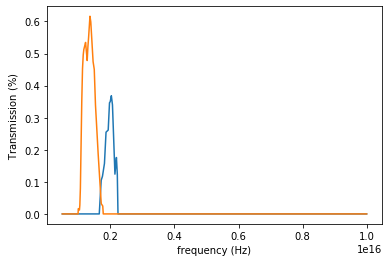

In [12]:
#plotting 

plt.plot(speed_of_light/obs_waves, fuv_freq(speed_of_light/obs_waves))
plt.plot(speed_of_light/obs_waves, nuv_freq(speed_of_light/obs_waves))
plt.xlabel('frequency (Hz)')
plt.ylabel('Transmission ($\%$)')

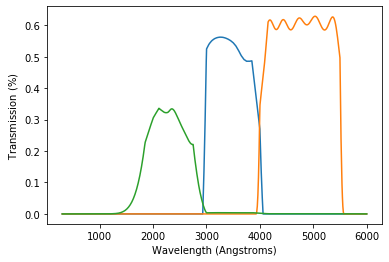

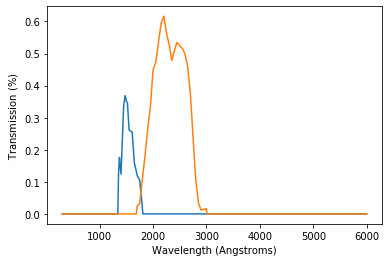

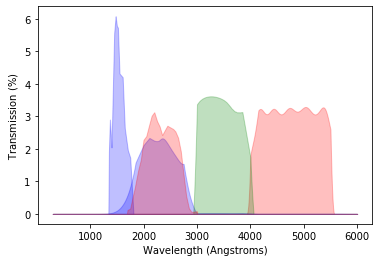

In [13]:
plt.plot(obs_waves, castor_u(speed_of_light/obs_waves))
plt.plot(obs_waves, castor_g(speed_of_light/obs_waves))
plt.plot(obs_waves, castor_uv(speed_of_light/obs_waves))
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Transmission ($\%$)')
plt.show()

plt.plot(obs_waves, fuv_freq(speed_of_light/obs_waves))
plt.plot(obs_waves, nuv_freq(speed_of_light/obs_waves))
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Transmission ($\%$)')
plt.show()

plt.fill_between(obs_waves, 0, castor_g(speed_of_light/obs_waves)/R_castor_g, color = 'red', alpha = 0.25)
plt.fill_between(obs_waves, 0, castor_uv(speed_of_light/obs_waves)/R_castor_uv, color = 'blue', alpha = 0.25)
plt.fill_between(obs_waves, 0, castor_u(speed_of_light/obs_waves)/R_castor_u, color = 'green', alpha = 0.25)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Transmission ($\%$)')
# plt.savefig('CASTOR_filters.png')
# plt.show()

plt.fill_between(obs_waves, 0, fuv_freq(speed_of_light/obs_waves)/R_fuv, color = 'blue', alpha = 0.25)
plt.fill_between(obs_waves, 0, nuv_freq(speed_of_light/obs_waves)/R_nuv, color = 'red', alpha = 0.25)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Transmission ($\%$)')
plt.savefig('GALEX_filters.png')
plt.show()



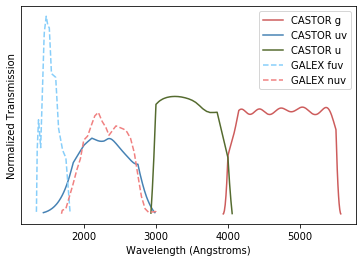

In [14]:
plt.plot(obs_waves[castor_g(speed_of_light/obs_waves)/R_castor_g > 0.01], np.array(castor_g(speed_of_light/obs_waves)/R_castor_g)[castor_g(speed_of_light/obs_waves)/R_castor_g > 0.01], color = 'indianred', label = 'CASTOR g')
plt.plot(obs_waves[castor_uv(speed_of_light/obs_waves)/R_castor_uv > 0.05], np.array(castor_uv(speed_of_light/obs_waves)/R_castor_uv)[castor_uv(speed_of_light/obs_waves)/R_castor_uv > 0.05], color = 'steelblue', label = 'CASTOR uv')
plt.plot(obs_waves[castor_u(speed_of_light/obs_waves)/R_castor_u > 0.01], np.array(castor_u(speed_of_light/obs_waves)/R_castor_u)[castor_u(speed_of_light/obs_waves)/R_castor_u > 0.01], color = 'darkolivegreen', label = 'CASTOR u')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Transmission ($\%$)')
# plt.savefig('CASTOR_filters.png')
# plt.show()

plt.plot(obs_waves[fuv_freq(speed_of_light/obs_waves)/R_fuv > 0.01],np.array(fuv_freq(speed_of_light/obs_waves)/R_fuv)[fuv_freq(speed_of_light/obs_waves)/R_fuv > 0.01], linestyle = 'dashed', color = 'lightskyblue', label = 'GALEX fuv')
plt.plot(obs_waves[nuv_freq(speed_of_light/obs_waves)/R_nuv > 0.01], np.array(nuv_freq(speed_of_light/obs_waves)/R_nuv)[nuv_freq(speed_of_light/obs_waves)/R_nuv > 0.01], linestyle = 'dashed', color = 'lightcoral', label = 'GALEX nuv')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Normalized Transmission')

plt.legend()

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,
    labelleft = False)

plt.savefig('Filters.pdf')
plt.show()

## Now compute the bias factor in the rest frame
These are related by $\nu = \nu_{obs} (1+z)$
need $b(\nu, z)$

In [15]:
#already defined nu_obs

#compute nu for a range of redshifts
zs = np.linspace(0.0, 4.0, 80) #for appropriate 0.05 Delta z redshift binning

nus = np.zeros((len(nu_obs), len(zs))) #the columns of this object are the frequencies at a given redshift

for i, z in enumerate(zs):
    nus[:, i] = nu_obs * (1+z)

## The bias function
is assumed to be $b(\nu, z) = b^{1500}_{z=0} \big(\frac{\nu}{\nu_{1500}}\big)^{\gamma_{b\nu}}(1+z)^{\gamma_{bz}}$

In [16]:
def b(nu, z):
    return b1500z0 * (nu/nu1500)**(gammabnu) * (1+z)**(gammabz)

In [17]:
print(gammabnu)
print(gammabz)

-0.86
0.79


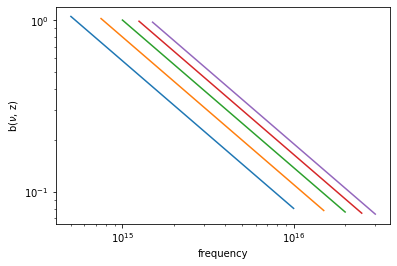

In [18]:
#plotting at a range of fixed redshifts

zs = [0.0, 0.5, 1.0, 1.5, 2.0]

for z in zs:
    nu = nu_obs * (1+z)
    plt.loglog(nu, b(nu, z))
    plt.xlabel('frequency')
    plt.ylabel(r'b($\nu$, z)')

## The emissivity model in the rest frame 
$\epsilon(\nu, z)$

To switch to evaluating the emissivity model in the rest frame for observed frequencies, need to incorporate
$\nu = \nu_{obs} (1+z)$.

Question: Ly-alpha should have amplitude EWLyA(z) in angstroms or in Hz, e.g. *$\nu^2$/c?

In [19]:
def delta(nu):
    """For a vector of frequencies, returns a value 1 at the frequency corresponding to 1216 angstroms and 0 elsewhere."""
    condlist = []
    funclist = [1, 0]
    return np.select(condlist, funclist)

def emissivity_model(theta, nu, z):
    """ 
    Returns a vector of emissivities in (units) for a set of input frequencies at a given redshift z. Here
    frequency is used in a general sense to indicate either frequency or wavelength. If the use_inverse boolean is set to 
    True, input wavelengths are internally converted to frequencies which are appropriate to the underlying emissivity 
    model, which is a piecewise power law (e proprtional to nu^alpha) with a lyman break and a lyman alpha delta function. 
    """
    
    log_e1500z0_b1500z0, gammae1500, alpha1500z0, Calpha1500, alpha1100z0, Calpha1100, EWLyAz03, EWLyAz1, gammabnu, gammabz, fLyCz2, fLyCz2 = theta
    #log_e1500z0_b1500z0, gammae1500, alpha1500z0, Calpha1500, alpha1100z0, Calpha1100, EWLyAz03, EWLyAz1, logfLyCz2, logfLyCz2 = theta

    
    condlist = [
                speed_of_light/nu > 1216.5,
                (1215.5 > (speed_of_light/nu)) * (912 <= speed_of_light/nu),
                (np.trunc(speed_of_light/nu)) >= 1215.5 * ((np.trunc(speed_of_light/nu)) <= 1216.5), 
                speed_of_light/nu < 912
                ]
    funclist = [
                 e1500(z, (10**(log_e1500z0_b1500z0))/b1500z0, gammae1500) * (nu/nu1500)**(alpha1500(z, Calpha1500, alpha1500z0)), 
        
                e1500(z, (10**(log_e1500z0_b1500z0))/b1500z0, gammae1500) *  (nu1216/nu1500)**(alpha1500(z, Calpha1500, alpha1500z0))*
                ((nu/nu1216)**alpha1100(z, Calpha1100, alpha1100z0)), 
        
                e1500(z, (10**(log_e1500z0_b1500z0))/b1500z0, gammae1500) *  (nu1216/nu1500)**(alpha1500(z, Calpha1500, alpha1500z0))*
                ((nu/nu1216)**alpha1100(z, Calpha1100, alpha1100z0) + EWLyA(z, EWLyAz1, EWLyAz03)), 
                #(nu**2)/speed_of_light),
        
                10**(logfLyC(z, logfLyCz2, logfLyCz1))*
                e1500(z, (10**(log_e1500z0_b1500z0))/b1500z0, gammae1500) *   (nu1216/nu1500)**alpha1500(z, Calpha1500, alpha1500z0) * 
                (nu912/nu1216)**alpha1100(z, Calpha1100, alpha1100z0) * (nu/nu912)**alpha900
                ] 
    return np.select(condlist, funclist)

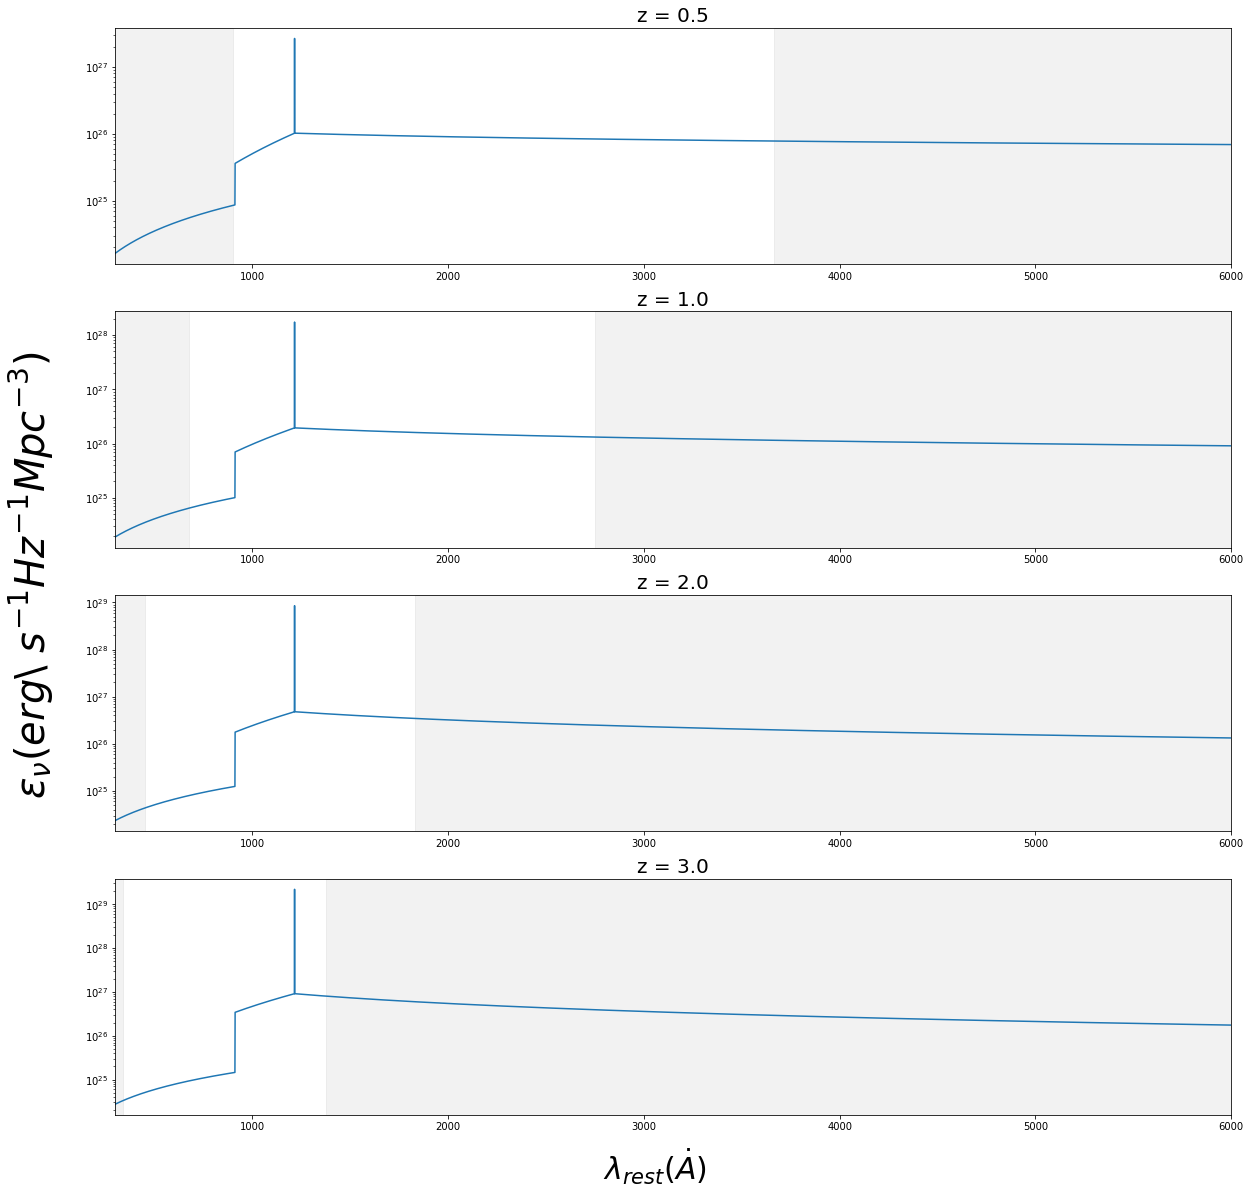

In [20]:
waves = np.linspace(300, 6000, 6000-499)

SED_zs = [0.5, 1, 2, 3]

def redshift(z, lambda_rest): 
    return lambda_rest/(1+z)
        
f = plt.figure(figsize=(20,20))

for i,z in enumerate(SED_zs):
    ax = f.add_subplot(len(SED_zs),1,i+1)
    ax.set_title('z = %1.1f' % SED_zs[i], fontsize = 20)
    ax.set_xlim(300, 6000)
    ax.semilogy(waves, emissivity_model(theta_1, speed_of_light/waves, z))
    ax.axvspan(redshift(SED_zs[i],300), redshift(SED_zs[i], 1350), color = 'grey', alpha=0.1)
    ax.axvspan(redshift(SED_zs[i], 5500), redshift(SED_zs[i],30000), color = 'grey', alpha=0.1)
    
    
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

    
f.text(0.5, 0.08, r'$\lambda_{rest} (\dot{A})$', ha='center', fontsize=30);
f.text(0.05, 0.5, r'$\epsilon_\nu (erg $\ $ s^{-1} Hz^{-1} Mpc^{-3})$', va='center', rotation='vertical', fontsize=40);

plt.savefig('Emissivity_model_can.png')

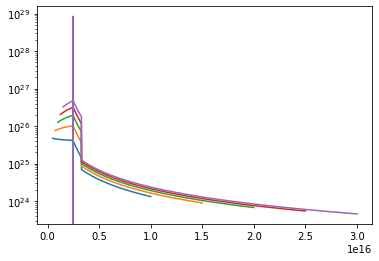

In [21]:
#evaluated at the frequency in the rest frame that corresponds to a given frequency in the observed fame
plt.semilogy(nu_obs * (1+0), emissivity_model(theta_1, nu_obs * (1+0), 0))
plt.semilogy(nu_obs * (1+0.5), emissivity_model(theta_1, nu_obs * (1+0.5), 0.5))
plt.semilogy(nu_obs * (1+1), emissivity_model(theta_1, nu_obs * (1+1), 1))
plt.semilogy(nu_obs * (1+1.5), emissivity_model(theta_1, nu_obs * (1+1.5), 1.5))
plt.semilogy(nu_obs * (1+2), emissivity_model(theta_1, nu_obs * (1+2), 2))

## With all the ingredients computed above, now it is time to compute the forward model integral

In [22]:
# will need the prefactor to be computed separately
# I think the issue may be the appropriate units for c? Ignoring c for now... 

def prefactor(z): 
    """
    Returns the multiplicative pre-factor the emissivity model. This is essentially the luminosity distance.
    Calls and requires the colossus cosmology to be set globally. Colossus is a convenience package of cosmology 
    functions. 
    """
    MPCtoCM = 3.086e24
    speed_of_light_km_s = 3*10**5
    return speed_of_light_km_s *(10**23)/(4*np.pi*(cosmology.Cosmology.Hz(cosmo, z)*(1+z))*(MPCtoCM**2))

## Emissivity Model Plus Optical Depth Factor for Lyman-Continuum

In [23]:
def optical_depth(nu, z):
    A = 4*10**7
    sigma_L = 6.3*10**(-18)
    prefactor = (4.0/3.0)*np.sqrt(np.pi * sigma_L)
    nu_L = 3.29 * 10**15 #Hz, Rydberg frequency
    nu_term = (nu/nu_L)**(-1.5)
    
    #note redshift term assumes z0 = 0
    
    redshift_term = (1**(1.5))*((1+z)**(1.5)-(1)**(1.5))
    
    return np.exp(-prefactor * A * nu_term * redshift_term)

Text(0, 0.5, '$\\tau_{eff}(nu=nu_L, z)$')

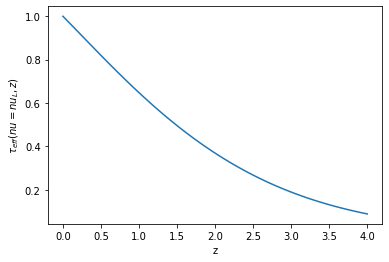

In [24]:
zs = np.linspace(0, 4, 80)

plt.plot(zs, optical_depth(3.29 * 10**15, zs))
plt.xlabel('z')
plt.ylabel(r'$\tau_{eff}(nu=nu_L, z)$')

In [25]:
def emissivity_model_optical_depth(theta, nu, z):
    """ 
    Returns a vector of emissivities in (units) for a set of input frequencies at a given redshift z. Here
    frequency is used in a general sense to indicate either frequency or wavelength. If the use_inverse boolean is set to 
    True, input wavelengths are internally converted to frequencies which are appropriate to the underlying emissivity 
    model, which is a piecewise power law (e proprtional to nu^alpha) with a lyman break and a lyman alpha delta function. 
    """
    
#     log_e1500z0_b1500z0, gammae1500, alpha1500z0, Calpha1500, alpha1100z0, Calpha1100, EWLyAz03, EWLyAz1, gammabnu, gammabz, fLyCz2, fLyCz2 = theta
#    log_e1500z0_b1500z0, gammae1500, alpha1500z0, Calpha1500, alpha1100z0, Calpha1100, EWLyAz1, gammabnu, gammabz, logfLyCz2, logfLyCz2 = theta
#*  (1+z)**(gammabz)
    
    EWLyAz03 = -6.17
    gammabnu, gammabz, log_e1500z0_b1500z0, gammae1500, alpha1500z0, Calpha1500, alpha1100z0, Calpha1100, EWLyAz1, logfLyCz2, logfLyCz2 = theta
    
    condlist = [
                speed_of_light/nu > 1216.5,
                (1215.5 > (speed_of_light/nu)) * (912 <= speed_of_light/nu),
                (np.trunc(speed_of_light/nu)) >= 1215.5 * ((np.trunc(speed_of_light/nu)) <= 1216.5), 
                speed_of_light/nu < 912
                ]
    funclist = [
                 e1500(z, (10**(log_e1500z0_b1500z0))/b1500z0, gammae1500) * (nu/nu1500)**(alpha1500(z, Calpha1500, alpha1500z0)), 
        
                (e1500(z, (10**(log_e1500z0_b1500z0))/b1500z0, gammae1500) *  (nu1216/nu1500)**(alpha1500(z, Calpha1500, alpha1500z0))*
                ((nu/nu1216)**alpha1100(z, Calpha1100, alpha1100z0)))*optical_depth(nu, z), 
        
                (e1500(z, (10**(log_e1500z0_b1500z0))/b1500z0, gammae1500) *  (nu1216/nu1500)**(alpha1500(z, Calpha1500, alpha1500z0))*
                ((nu/nu1216)**alpha1100(z, Calpha1100, alpha1100z0) + EWLyA(z, EWLyAz1, EWLyAz03)))*optical_depth(nu, z), 
                #(nu**2)/speed_of_light),
        
                10**(logfLyC(z, logfLyCz2, logfLyCz1))*
                e1500(z, (10**(log_e1500z0_b1500z0))/b1500z0, gammae1500)  * (nu1216/nu1500)**alpha1500(z, Calpha1500, alpha1500z0) * 
                (nu912/nu1216)**alpha1100(z, Calpha1100, alpha1100z0) * (nu/nu912)**alpha900
                ] 
    return np.select(condlist, funclist)

In [26]:
def biased_weighted_emissivity_castor(theta, z):
    
    #over some observed wavelengths
    
    obs_waves = np.linspace(300, 6000, 6000-299)
    nu_obs = speed_of_light/obs_waves
    inverse_nu_obs = 1.0/nu_obs
    
    # compute each term in this integral
    inverse_nu_obs = 1.0/nu_obs 
    
    # in this case, the galex nuv curve R_nuv (nu_obs)
    
    R_nu_obs_u = castor_u(nu_obs)
    R_nu_obs_uv = castor_uv(nu_obs)
    R_nu_obs_g = castor_g(nu_obs)

    # the bias factor, evaluated in the rest frame nu = nu_obs (1+z)
    
    bias_nu = b(nu_obs * (1+z), z)
    
    # and the emissivity model itself 
    
    e_nu_z = emissivity_model_optical_depth(theta, nu_obs * (1+z), z)
    
    # and perform the integral
    #syntax for np.trapz is (f(x), x)
    
    dJdz_bj_u = prefactor(z)/R_castor_u * np.abs(np.trapz(R_nu_obs_u * bias_nu * e_nu_z *inverse_nu_obs, nu_obs))
    dJdz_bj_uv = prefactor(z)/R_castor_uv * np.abs(np.trapz(R_nu_obs_uv * bias_nu * e_nu_z *inverse_nu_obs, nu_obs))
    dJdz_bj_g = prefactor(z)/R_castor_g * np.abs(np.trapz(R_nu_obs_g * bias_nu * e_nu_z *inverse_nu_obs, nu_obs))
    

    return np.array([dJdz_bj_uv, dJdz_bj_u, dJdz_bj_g])

In [27]:
biased_weighted_emissivity_castor(theta, 1)

array([ 54.16907555, 106.38378723, 120.16979062])

In [28]:
def biased_weighted_emissivity_nuv(theta, z):
    
    #over some observed wavelengths
    
    obs_waves = np.linspace(1700, 3000, 3000-1699)
    nu_obs = speed_of_light/obs_waves
    inverse_nu_obs = 1.0/nu_obs
    
    # compute each term in this integral
    inverse_nu_obs = 1.0/nu_obs 
    
    # in this case, the galex nuv curve R_nuv (nu_obs)
    
    R_nu_obs = nuv_freq(nu_obs)
    
    # the bias factor, evaluated in the rest frame nu = nu_obs (1+z)
    
    bias_nu = b(nu_obs * (1+z), z)
    
    # and the emissivity model itself 
    
    e_nu_z = emissivity_model_optical_depth(theta, nu_obs * (1+z), z)
    
    # and perform the integral
    
    #syntax for np.trapz is (f(x), x)
    return prefactor(z)/R_nuv * np.abs(np.trapz(R_nu_obs * bias_nu * e_nu_z *inverse_nu_obs, nu_obs))
    

In [29]:
# norm = 1/(4.*np.pi)/MPCTOCM**2
# dx_phys = dz/HubbleZ(zmean)/(1+zmean)*LIGHT_SPEED_KMSEC
# Jnu = ((1.+z-dz)/(1.+z))**3 *np.exp(-dtaueffdx_cont*dx_phys)*(Jnu + norm*dx_phys*(1.+zmean)**3*emissivityFuncComoving(E_ARR_Z0*(1+zmean), zmean))

In [30]:
# and plot
zs = np.linspace(0.0, 3.0, 80)

dJdz_b = np.zeros(len(zs))

for i, z in enumerate(zs):
    dJdz_b[i] = biased_weighted_emissivity_nuv(theta, z)

In [31]:
#np.trapz(dJdz_b/b_z_uv, zs)

In [32]:
# plt.plot(zs, (dJdz_b)/b_nuvs)
# plt.xlabel('z')
# plt.ylabel('dJ/dz $b_j$(z)')
# plt.title('nuv')
# plt.ylim(0, 500)
# plt.xlim(0, 3)

nuv = 208.47353204278357


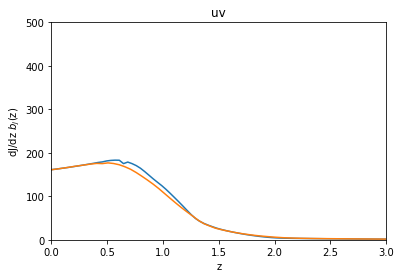

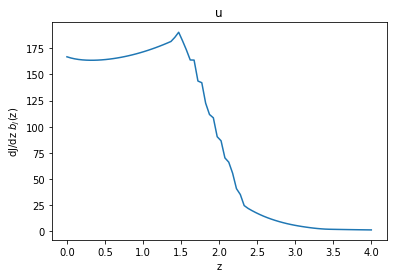

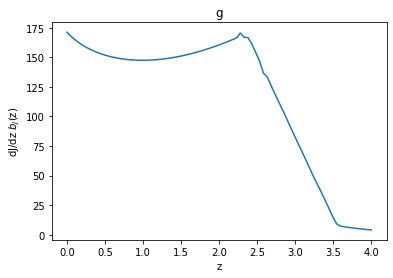

uv = 201.6318754298165
u = 354.76017545310964
g = 473.75990162441474


In [33]:
def biased_weighted_emissivity_nuv_2(theta, z):
    
    #over some observed wavelengths
    
    obs_waves = np.linspace(1700, 3000, 3000-1699)
    nu_obs = speed_of_light/obs_waves
    inverse_nu_obs = 1.0/nu_obs
    
    # compute each term in this integral
    inverse_nu_obs = 1.0/nu_obs 
    
    # in this case, the galex nuv curve R_nuv (nu_obs)
    
    R_nu_obs = nuv_freq(nu_obs)
    
    # the bias factor, evaluated in the rest frame nu = nu_obs (1+z)
    
    #bias_nu = b(nu_obs * (1+z), z)
    bias_nu = 1
    
    # and the emissivity model itself 
    
    e_nu_z = emissivity_model_optical_depth(theta, nu_obs * (1+z), z)
    
    # and perform the integral
    
    #syntax for np.trapz is (f(x), x)
    return prefactor(z)/R_nuv * np.abs(np.trapz(R_nu_obs * bias_nu * e_nu_z *inverse_nu_obs, nu_obs))


zs = np.linspace(0.0, 3.0, 80)

dJdz_b = np.zeros(len(zs))

for i, z in enumerate(zs):
    dJdz_b[i] = biased_weighted_emissivity_nuv_2(theta, z)

plt.plot(zs, (dJdz_b))
plt.xlabel('z')
plt.ylabel('dJ/dz $b_j$(z)')
plt.title('nuv')
plt.ylim(0, 500)
plt.xlim(0, 3)    

print('nuv = {}'.format(np.trapz(dJdz_b, zs)))


# b_nuvs = b2(1539, zs)
# b_nuvs
# np.trapz((dJdz_b)/b_nuvs, zs)

def biased_weighted_emissivity_castor_2(theta, z):
    
    #over some observed wavelengths
    
    obs_waves = np.linspace(300, 6000, 6000-299)
    nu_obs = speed_of_light/obs_waves
    inverse_nu_obs = 1.0/nu_obs
    
    # compute each term in this integral
    inverse_nu_obs = 1.0/nu_obs 
    
    # in this case, the galex nuv curve R_nuv (nu_obs)
    
    R_nu_obs_u = castor_u(nu_obs)
    R_nu_obs_uv = castor_uv(nu_obs)
    R_nu_obs_g = castor_g(nu_obs)

    # the bias factor, evaluated in the rest frame nu = nu_obs (1+z)
    
    #bias_nu = b(nu_obs * (1+z), z)
    bias_nu = 1
    
    # and the emissivity model itself 
    
    e_nu_z = emissivity_model_optical_depth(theta, nu_obs * (1+z), z)
    
    # and perform the integral
    #syntax for np.trapz is (f(x), x)
    
    dJdz_bj_u = prefactor(z)/R_castor_u * np.abs(np.trapz(R_nu_obs_u * bias_nu * e_nu_z *inverse_nu_obs, nu_obs))
    dJdz_bj_uv = prefactor(z)/R_castor_uv * np.abs(np.trapz(R_nu_obs_uv * bias_nu * e_nu_z *inverse_nu_obs, nu_obs))
    dJdz_bj_g = prefactor(z)/R_castor_g * np.abs(np.trapz(R_nu_obs_g * bias_nu * e_nu_z *inverse_nu_obs, nu_obs))
    

    return np.array([dJdz_bj_uv, dJdz_bj_u, dJdz_bj_g])


zs = np.linspace(0.0, 4.0, 80)

dJdz_b_uv = np.zeros(len(zs))
dJdz_b_u = np.zeros(len(zs))
dJdz_b_g = np.zeros(len(zs))

for i, z in enumerate(zs):
    dJdz_b_uv[i] = biased_weighted_emissivity_castor_2(theta, z)[0]
    dJdz_b_u[i] = biased_weighted_emissivity_castor_2(theta, z)[1]
    dJdz_b_g[i] = biased_weighted_emissivity_castor_2(theta, z)[2]
    
plt.plot(zs, (dJdz_b_uv))
plt.xlabel('z')
plt.ylabel('dJ/dz $b_j$(z)')
plt.title('uv')
plt.show()

plt.plot(zs, (dJdz_b_u))
plt.xlabel('z')
plt.ylabel('dJ/dz $b_j$(z)')
plt.title('u')
plt.show()

plt.plot(zs, (dJdz_b_g))
plt.xlabel('z')
plt.ylabel('dJ/dz $b_j$(z)')
plt.title('g')
plt.show()

print('uv = {}'.format(np.trapz(dJdz_b_uv, zs)))
print('u = {}'.format(np.trapz(dJdz_b_u, zs)))
print('g = {}'.format(np.trapz(dJdz_b_g, zs)))

In [34]:
#discrepant at the 20% level. 

#Jy/Sr --> photon units

print(201 / (1.0E+26 * 1000) * (1.50918896E+22) / 0.230 * 10**6)
print(354 / (1.0E+26 * 1000) * (1.50918896E+22) / 0.230 * 10**6)
print(473 / (1.0E+26 * 1000) * (1.50918896E+22) / 0.230 * 10**6)

131.88999172173914
232.2838660173913
310.3679904695652


In [35]:
zs = np.linspace(0.0, 3.0, 80)

dJdz_b = np.zeros(len(zs))

for i, z in enumerate(zs):
    dJdz_b[i] = biased_weighted_emissivity_nuv(theta, z)

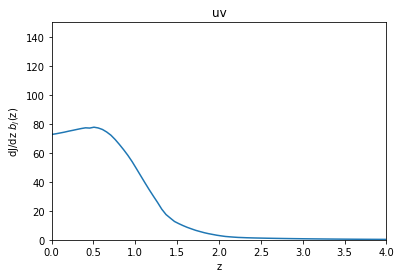

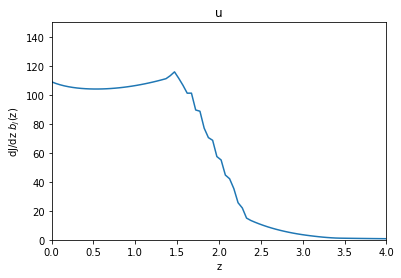

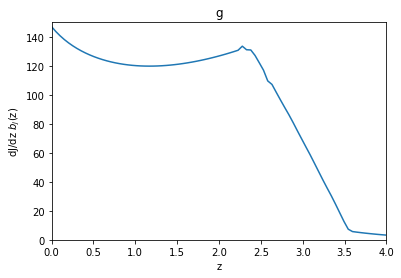

In [36]:
# and plot
zs = np.linspace(0.0, 4.0, 80)

dJdz_b_uv = np.zeros(len(zs))
dJdz_b_u = np.zeros(len(zs))
dJdz_b_g = np.zeros(len(zs))

for i, z in enumerate(zs):
    dJdz_b_uv[i] = biased_weighted_emissivity_castor(theta, z)[0]
    dJdz_b_u[i] = biased_weighted_emissivity_castor(theta, z)[1]
    dJdz_b_g[i] = biased_weighted_emissivity_castor(theta, z)[2]
    
plt.plot(zs, (dJdz_b_uv))
plt.xlabel('z')
plt.ylabel('dJ/dz $b_j$(z)')
plt.title('uv')
plt.ylim(0, 150)
plt.xlim(0, 4)
plt.show()

plt.plot(zs, (dJdz_b_u))
plt.xlabel('z')
plt.ylabel('dJ/dz $b_j$(z)')
plt.title('u')
plt.ylim(0, 150)
plt.xlim(0, 4)
plt.show()

plt.plot(zs, (dJdz_b_g))
plt.xlabel('z')
plt.ylabel('dJ/dz $b_j$(z)')
plt.title('g')
plt.ylim(0, 150)
plt.xlim(0, 4)
plt.show()

In [37]:
# let's try with fuv

(0, 60)

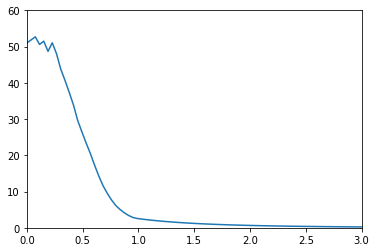

In [38]:
def biased_weighted_emissivity_fuv(theta, z):
    
    #over some observed wavelengths
    
    nu_obs = speed_of_light/obs_waves
    inverse_nu_obs = 1.0/nu_obs
    
    # compute each term in this integral
    inverse_nu_obs = 1.0/nu_obs 
    
    # in this case, the galex nuv curve R_nuv (nu_obs)
    
    R_nu_obs = fuv_freq(nu_obs)
    
    # the bias factor, evaluated in the rest frame nu = nu_obs (1+z)
    
    bias_nu = b(nu_obs * (1+z), z)
    
    # and the emissivity model itself 
    
    e_nu_z = emissivity_model_optical_depth(theta, nu_obs * (1+z), z)
    
    # and perform the integral
    
    #syntax for np.trapz is (f(x), x)
    return prefactor(z)/R_fuv * np.abs(np.trapz(inverse_nu_obs * R_nu_obs * bias_nu * e_nu_z, nu_obs))

# and plot
zs = np.linspace(0.0, 3.0, 80)

dJdz_b = np.zeros(len(zs))

for i, z in enumerate(zs):
    dJdz_b[i] = biased_weighted_emissivity_fuv(theta, z)
    
plt.plot(zs, dJdz_b)
plt.xlim(0,3)
plt.ylim(0,60)

In [39]:
# which also seems to agree? okay - i give up!

# could this be a numerical integration thing related to the fact that the emissivity model is evaluated in frequency
# but for fixed wavelength sampling? 

In [41]:
def theta_max(z):
    ang_dist = cosmo.angularDiameterDistance(z) #Mpc/h
    #return 1 * (np.pi/180)
    return 5/ang_dist 

In [69]:
# for line in paper about clustering scale vs redshift. 

cosmo.comovingDistance(z_min=0.001, z_max=0.002)

2.9958243090777663

In [68]:
0.01/np.sqrt(0.05)

0.044721359549995794

# Section 4: OLD Error Model - DO NOT RUN THIS SECTION

Not updated with current fitting functions

In [41]:
# #rewriting the error model

# def theta_max(z):
#     ang_dist = cosmo.angularDiameterDistance(z) #Mpc/h
#     #return 1 * (np.pi/180)
#     return 5/ang_dist 

# #approximating b(nu, z) by its value at the mean frequency

# def b_eff(z): 
#     uv_mean = np.mean(nu_obs[castor_uv(nu_obs) > 0.01])
#     u_mean = np.mean(nu_obs[castor_u(nu_obs) > 0.01])
#     g_mean = np.mean(nu_obs[castor_g(nu_obs) > 0.01])
#     return [0.32*(uv_mean/nu1500)**(-0.86) * (1+z)**(0.79), 0.32*(u_mean/nu1500)**(-0.86) * (1+z)**(0.79), 0.32*(g_mean/nu1500)**(-0.86) * (1+z)**(0.79)]

# def b_mstar(z):
#     return 0.072 * (1 + z)**(2.90) + 1.257 



In [42]:
# zs = np.linspace(0.01, 4, 80)
# (15*(theta_max(1)*(180/np.pi)))**2

13.994135696865914

## Use Cosmic Variance Fitting Function for Survey 
nearest to 5 Mpc Comoving Angular Scale - GEMS survey is closest 

In [43]:
# sigma_a = 0.161
# sigma_b = 0.520
# Beta = 0.729
# redshift_bin = 0.01 

# def dm_var(z):
#     return (sigma_a / (z**Beta + sigma_b)) #* np.sqrt(0.2/redshift_bin)

# def cosmic_var(z):
#     return [b_eff(z)[0]*b_mstar(z)*dm_var(z)**2, b_eff(z)[1]*b_mstar(z)*dm_var(z)**2, b_eff(z)[2]*b_mstar(z)*dm_var(z)**2]

## Shot Noise Contribution
See Wolz (2017b) for derivation of this noise term expressed in terms of the Power Spectra
This works nearly the same for the correlation function

The result is the shot noise fractional error is 

In [44]:
# def shot_noise(theta_max, n_galaxies):
#     return np.pi * theta_max**2 * (180**2/(np.pi**2)) * n_galaxies

In [45]:
# #plotting the noise model

# cosmic_variance_error = np.zeros((80))
# shot_noise_error = np.zeros((80))

# for i,z in enumerate(np.linspace(0, 4, 80)):
#     cosmic_variance_error[i] = cosmic_var(z)[0]*np.sqrt(0.2/0.05)  
    
# for i,z in enumerate(np.linspace(0.05, 4, 80)):
#     shot_noise_error[i] = 1/shot_noise(theta_max(z), 80)
    
# ## Assuming 10 fields 
# n_fields = 10 
# cosmic_var_line, = plt.plot(np.linspace(0, 4, 80), (cosmic_variance_error)**2/n_fields, '.')
# shot_var_line, = plt.plot(np.linspace(0.05,4, 80), shot_noise_error, '+')
# phot_var_line = plt.hlines(0.01, min(zs), 4.0, linestyles='dashed')

# plt.legend((cosmic_var_line, shot_var_line, phot_var_line), ('Cosmic Variance', 'Shot Noise', 'Photometric Zero Point'))
# plt.title('Fractional Error Budget')
# plt.xlabel('Redshift z')
# plt.ylabel(r'$\sigma^2$')

In [46]:
# (1/np.sqrt((shot_noise(theta_max(4), 20))))/10

In [47]:
# theta_max(1)*180/np.pi

## Error Propagation

In [48]:
# #def tot_err(cosmic_var, shot_noise, n_fields):
# #    return np.sqrt((cosmic_var**2)/n_fields + 0.01**2) + (1/(shot_noise)) 

# def tot_err(cosmic_var, shot_noise, n_fields):
#     return np.sqrt((cosmic_var/n_fields) + (1/(n_fields * shot_noise)) + 0.01**2) 

# def frac_errors(z, n_galaxies, n_fields):
#     shot = shot_noise(theta_max(z), n_galaxies)
#     cosmic = (np.array(cosmic_var(z))*0.2/0.05) #returns 3x1 vector, 1 for each castor filter
    
#     tot_error_uv = tot_err(cosmic[0], shot, n_fields)
#     tot_error_u = tot_err(cosmic[1], shot, n_fields)
#     tot_error_g = tot_err(cosmic[2], shot, n_fields)
#     return np.array([tot_error_uv, tot_error_u, tot_error_g])

[0.22082187 0.15592589 0.13066752 0.1147683  0.10356125 0.09517001
 0.08864183 0.08342754 0.07918335 0.07568105 0.07276227 0.07031318
 0.06824962 0.06650788 0.06503876 0.06380361 0.06277164 0.06191795
 0.06122222 0.06066769 0.06024036 0.05992853 0.05972225 0.05961307
 0.05959374 0.05965802 0.05980049 0.06001644 0.06030175 0.06065279
 0.06106638 0.0615397  0.06207024 0.06265576 0.06329429 0.06398404
 0.06472342 0.06551098 0.06634544 0.06722563 0.06815048 0.06911905
 0.07013046 0.07118393 0.07227873 0.07341422 0.0745898  0.07580492
 0.07705909 0.07835185 0.07968279 0.08105153 0.08245773 0.08390105
 0.08538122 0.08689796 0.08845103 0.0900402  0.09166528 0.09332606
 0.09502239 0.09675411 0.09852106 0.10032313 0.1021602  0.10403214
 0.10593888 0.10788032 0.10985638 0.11186699 0.11391208 0.1159916
 0.1181055  0.12025374 0.12243627 0.12465306 0.12690408 0.12918932
 0.13150875 0.13386235]
[0.00257333 0.00915242 0.01837593 0.02924718 0.04103718 0.05321476
 0.06539677 0.07731231 0.08877281 0.099

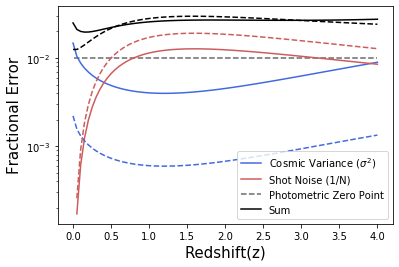

In [49]:
# # Plot for UV filter

# cosmic_variance_error = np.zeros((80))
# shot_noise_error = np.zeros((80))

# for i,z in enumerate(np.linspace(0, 4, 80)):
#     cosmic_variance_error[i] = cosmic_var(z)[0]*0.2/0.05
    
# for i,z in enumerate(np.linspace(0.05, 4, 80)):
#     shot_noise_error[i] = 1/shot_noise(theta_max(z), 30)
    
# print(cosmic_variance_error)
# print(shot_noise_error)

    
# ## Assuming 10 fields 
# n_fields = 15 
# cosmic_var_line, = plt.semilogy(np.linspace(0, 4, 80), (cosmic_variance_error)/n_fields, color = 'royalblue')
# shot_var_line, = plt.semilogy(np.linspace(0.05,4, 80), shot_noise_error/n_fields, color = 'indianred')
# phot_var_line = plt.hlines(0.01, min(zs), 4.0, linestyles='dashed', color = 'dimgrey')

# #add sum line

# #tot_err_line, = plt.semilogy(np.linspace(0, 4, 80), frac_errors(np.linspace(0, 4, 80), 30, 15)[0], color = 'black')
# tot_err_line, = plt.semilogy(np.linspace(0, 4, 80), (cosmic_variance_error)/n_fields + shot_noise_error/n_fields + 0.01 , color = 'black')


# #comment below to remove Yi-Kuan example
# shot_noise_error_2 = np.zeros(80)
# for i,z in enumerate(np.linspace(0.05, 4, 80)):
#     shot_noise_error_2[i] = 1/shot_noise(theta_max(z), 3)
    
# print(cosmic_variance_error)
# print(shot_noise_error)

    
# ## Assuming 100 fields and 3 objects per field
# n_fields = 100 
# cosmic_var_line_2, = plt.semilogy(np.linspace(0, 4, 80), (cosmic_variance_error)/n_fields, color = 'royalblue', linestyle = 'dashed')
# shot_var_line_2, = plt.semilogy(np.linspace(0.05,4, 80), shot_noise_error_2/n_fields, color = 'indianred', linestyle = 'dashed')
# #phot_var_line = plt.hlines(0.01, min(zs), 4.0, linestyles='dashed', color = 'dimgrey')

# tot_err_line_2, = plt.semilogy(np.linspace(0, 4, 80), (cosmic_variance_error)/n_fields + shot_noise_error_2/n_fields + 0.01 , color = 'black', linestyle = 'dashed')



# plt.legend((cosmic_var_line, shot_var_line, phot_var_line, tot_err_line), ('Cosmic Variance ($\sigma^2$)', 'Shot Noise (1/N)', 'Photometric Zero Point', 'Sum'))
# #plt.title('Error due to Cosmic Variance')
# plt.xlabel('Redshift(z)', fontsize = 15)
# plt.ylabel('Fractional Error', fontsize = 15)

# #plt.savefig('Error_model_11.pdf') #original error_model_85.pdf had N= 20 instead of N=30! 
# plt.savefig('comparison.pdf')

# # y_vals = plt.get_yticks()
## plt.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in y_vals])

[0.22082187 0.15592589 0.13066752 0.1147683  0.10356125 0.09517001
 0.08864183 0.08342754 0.07918335 0.07568105 0.07276227 0.07031318
 0.06824962 0.06650788 0.06503876 0.06380361 0.06277164 0.06191795
 0.06122222 0.06066769 0.06024036 0.05992853 0.05972225 0.05961307
 0.05959374 0.05965802 0.05980049 0.06001644 0.06030175 0.06065279
 0.06106638 0.0615397  0.06207024 0.06265576 0.06329429 0.06398404
 0.06472342 0.06551098 0.06634544 0.06722563 0.06815048 0.06911905
 0.07013046 0.07118393 0.07227873 0.07341422 0.0745898  0.07580492
 0.07705909 0.07835185 0.07968279 0.08105153 0.08245773 0.08390105
 0.08538122 0.08689796 0.08845103 0.0900402  0.09166528 0.09332606
 0.09502239 0.09675411 0.09852106 0.10032313 0.1021602  0.10403214
 0.10593888 0.10788032 0.10985638 0.11186699 0.11391208 0.1159916
 0.1181055  0.12025374 0.12243627 0.12465306 0.12690408 0.12918932
 0.13150875 0.13386235]
[0.02573333 0.09152422 0.18375928 0.29247175 0.41037182 0.53214755
 0.65396771 0.77312307 0.88772813 0.996

Text(0, 0.5, 'Fractional Error')

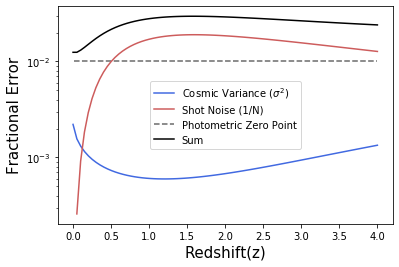

In [50]:
# Plot for a more realistic combined catalog

# cosmic_variance_error = np.zeros((80))
# shot_noise_error = np.zeros((80))

# for i,z in enumerate(np.linspace(0, 4, 80)):
#     cosmic_variance_error[i] = cosmic_var(z)[0]*0.2/0.05
    
# for i,z in enumerate(np.linspace(0.05, 4, 80)):
#     shot_noise_error[i] = 1/shot_noise(theta_max(z), 3)
    
# print(cosmic_variance_error)
# print(shot_noise_error)

    
# ## Assuming 100 fields and 3 objects per field
# n_fields = 100 
# cosmic_var_line, = plt.semilogy(np.linspace(0, 4, 80), (cosmic_variance_error)/n_fields, color = 'royalblue')
# shot_var_line, = plt.semilogy(np.linspace(0.05,4, 80), shot_noise_error/n_fields, color = 'indianred')
# phot_var_line = plt.hlines(0.01, min(zs), 4.0, linestyles='dashed', color = 'dimgrey')

# #add sum line

# #tot_err_line, = plt.semilogy(np.linspace(0, 4, 80), frac_errors(np.linspace(0, 4, 80), 30, 15)[0], color = 'black')
# tot_err_line, = plt.semilogy(np.linspace(0, 4, 80), (cosmic_variance_error)/n_fields + shot_noise_error/n_fields + 0.01 , color = 'black')



# plt.legend((cosmic_var_line, shot_var_line, phot_var_line, tot_err_line), ('Cosmic Variance ($\sigma^2$)', 'Shot Noise (1/N)', 'Photometric Zero Point', 'Sum'))
# #plt.title('Error due to Cosmic Variance')
# plt.xlabel('Redshift(z)', fontsize = 15)
# plt.ylabel('Fractional Error', fontsize = 15)

# #plt.savefig('Error_model_11.pdf') #original error_model_85.pdf had N= 20 instead of N=30! 

# # y_vals = plt.get_yticks()
# # plt.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in y_vals])

[0.22082187 0.15592589 0.13066752 0.1147683  0.10356125 0.09517001
 0.08864183 0.08342754 0.07918335 0.07568105 0.07276227 0.07031318
 0.06824962 0.06650788 0.06503876 0.06380361 0.06277164 0.06191795
 0.06122222 0.06066769 0.06024036 0.05992853 0.05972225 0.05961307
 0.05959374 0.05965802 0.05980049 0.06001644 0.06030175 0.06065279
 0.06106638 0.0615397  0.06207024 0.06265576 0.06329429 0.06398404
 0.06472342 0.06551098 0.06634544 0.06722563 0.06815048 0.06911905
 0.07013046 0.07118393 0.07227873 0.07341422 0.0745898  0.07580492
 0.07705909 0.07835185 0.07968279 0.08105153 0.08245773 0.08390105
 0.08538122 0.08689796 0.08845103 0.0900402  0.09166528 0.09332606
 0.09502239 0.09675411 0.09852106 0.10032313 0.1021602  0.10403214
 0.10593888 0.10788032 0.10985638 0.11186699 0.11391208 0.1159916
 0.1181055  0.12025374 0.12243627 0.12465306 0.12690408 0.12918932
 0.13150875 0.13386235]
[0.02573333 0.09152422 0.18375928 0.29247175 0.41037182 0.53214755
 0.65396771 0.77312307 0.88772813 0.996

Text(0, 0.5, 'Fractional Error')

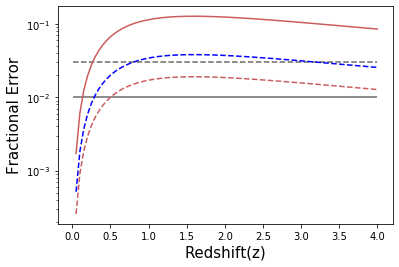

In [51]:
# Plot for a more realistic combined catalog

# cosmic_variance_error = np.zeros((80))
# shot_noise_error = np.zeros((80))
# shot_noise_error_2 = np.zeros((80))

# for i,z in enumerate(np.linspace(0, 4, 80)):
#     cosmic_variance_error[i] = cosmic_var(z)[0]*0.2/0.05
    
# for i,z in enumerate(np.linspace(0.05, 4, 80)):
#     shot_noise_error[i] = 1/shot_noise(theta_max(z), 3)
    
# for i,z in enumerate(np.linspace(0.05, 4, 80)):
#     shot_noise_error_2[i] = 1/shot_noise(theta_max(z), 30)
    
# print(cosmic_variance_error)
# print(shot_noise_error)

    
# ## Assuming 100 fields and 3 objects per field
# n_fields = 100 
# shot_var_line, = plt.semilogy(np.linspace(0.05,4, 80), shot_noise_error/100, color = 'indianred', linestyle = 'dashed')
# shot_var_line, = plt.semilogy(np.linspace(0.05,4, 80), shot_noise_error/15, color = 'indianred')
# phot_var_line = plt.hlines(0.01, min(zs), 4.0, color = 'dimgrey')
# phot_var_line = plt.hlines(0.03, min(zs), 4.0, linestyles='dashed', color = 'dimgrey')
# shot_var_line, = plt.semilogy(np.linspace(0.05,4, 80), shot_noise_error/50, color = 'blue', linestyle = 'dashed')


# #add sum line

# #tot_err_line, = plt.semilogy(np.linspace(0, 4, 80), frac_errors(np.linspace(0, 4, 80), 30, 15)[0], color = 'black')



# #plt.title('Error due to Cosmic Variance')
# plt.xlabel('Redshift(z)', fontsize = 15)
# plt.ylabel('Fractional Error', fontsize = 15)


In [52]:
#(440220 + 330644 + 616571 + 107365 + 48602)/1782805

0.8657155437639001

In [53]:
#((440220 + 330644 + 616571 + 107365 + 48602))/(30.0 * 8307)

6.193178443882669

In [54]:
# n1 = 440220
# n2 = 330644
# n3 = 616571
# n4 = 107365
# n5 = 48602
# n6 = 90080
# n7 = 14323

In [55]:
# r1 = np.linspace(0.09 - 0.04, 0.09+0.06) #--> 2
# r2 = np.linspace(0.31 - 0.15, 0.31+0.09) # 5
# r3 = np.linspace(0.54 - 0.07, 0.54+0.09) # 3
# r4 = np.linspace(0.68 - 0.13, 0.68+0.07) #4
# r5 = np.linspace(1.48 - 0.80, 1.48+0.87) # 33
# r6 = np.linspace(2.43 - 0.23, 2.43+0.51) # 15
# r7 = np.linspace(1.60 - 0.62, 1.60+0.57) # 24

# r = r4
# print((np.max(r)-np.min(r))/0.05)
# print((np.max(r)-np.min(r)))

3.999999999999999
0.19999999999999996


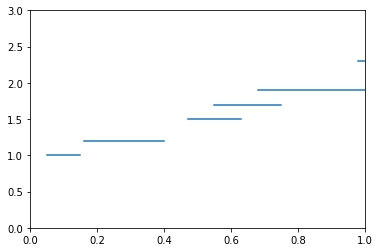

In [56]:
# plt.xlim(0, 1)
# plt.ylim(0,3)
# plt.axhline(1, xmin = np.min(r1), xmax=np.max(r1))
# plt.axhline(1.2, xmin = np.min(r2), xmax=np.max(r2))
# plt.axhline(1.5, xmin = np.min(r3), xmax=np.max(r3))
# plt.axhline(1.7, xmin = np.min(r4), xmax=np.max(r4))
# plt.axhline(1.9, xmin = np.min(r5), xmax=np.max(r5))
# plt.axhline(2.1, xmin = np.min(r6), xmax=np.max(r6))
# plt.axhline(2.3, xmin = np.min(r7), xmax=np.max(r7))

In [57]:
# print(n1/(2*7342)) #galaxies per bin per degree
# print(n2/(5*7554))
# print(n3/(3*8307))
# print(n4/(4*2210))
# print(n5/(33*5806))
# print(n6/(15*8146))
# print(n7/(24*2258))

29.97956959956415
8.75414350013238
24.74102162834557
12.145361990950226
0.2536665309658765
0.7372125378508879
0.26430100383820493


In [58]:
# f1 = (1/((7342/(theta_max(0.09)*180/np.pi)))) *cosmic_var(0.09)[0]*0.2/0.05 * (1/theta_max(0.09)**2)
# f2 = (1/((7554/(theta_max(0.31)*180/np.pi)))) *cosmic_var(0.31)[0]*0.2/0.05 * (1/theta_max(0.31)**2)
# f3 = (1/((8307/(theta_max(0.54)*180/np.pi)))) *cosmic_var(0.54)[0]*0.2/0.05 * (1/theta_max(0.54)**2)
# f4 = (1/((2210/(theta_max(0.68)*180/np.pi)))) *cosmic_var(0.68)[0]*0.2/0.05 * (1/theta_max(0.68)**2)
# f5 = (1/((5806/(theta_max(1.48)*180/np.pi)))) *cosmic_var(1.48)[0]*0.2/0.05 * (1/theta_max(1.48)**2)
# f6 = (1/((8146/(theta_max(2.43)*180/np.pi)))) *cosmic_var(2.43)[0]*0.2/0.05 * (1/theta_max(2.43)**2)
# f7 = (1/((2258/(theta_max(1.60)*180/np.pi)))) *cosmic_var(1.60)[0]*0.2/0.05 * (1/theta_max(1.60)**2)

In [59]:
# (0.13/(2200/(theta_max(0.68)*180/np.pi))) * (1/(theta_max(0.68)*180/np.pi)**2)

0.00020927952242737023

4.865619693433522e-06
1.6161481852166362


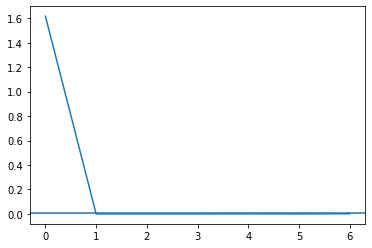

In [60]:
# f1 = (1/(n1/(2*(7342/theta_max(0.09))))) #galaxies per bin per degree
# f2 = (1/(n2/5))
# f3 = (1/(n3/3))
# f4 = (1/(n4/4))
# f5 = (1/(n5/33))
# f6 = (1/(n6/15))
# f7 = (1/(n7/24))

# plt.plot([f1, f2, f3, f4, f5, f6, f7])
# plt.axhline(0.01)

# print(np.min([f1, f2, f3, f4, f5, f6, f7]))
# print(np.max([f1, f2, f3, f4, f5, f6, f7]))

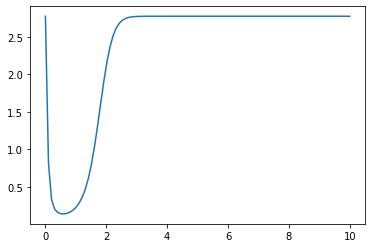

In [92]:
# dndzs = np.load('dndzs.npy')
# zz = np.linspace(0.0, 10, 100)

# plt.plot(zz, 1/(0.001*360 + ((0.17-0.001)*360*dndzs)/np.trapz(dndzs)))

In [94]:
# print(n1/7342/360)
# print(n2/7554/360)
# print(n3/8307/360)
# print(n4/2210/360)
# print(n5/5806/360)
# print(n6/8146/360)
# print(n7/2258/360)

0.16655316444202306
0.12158532639072751
0.20617518023621312
0.13494846656611362
0.023252765338538678
0.030717189077120333
0.017620066922546994


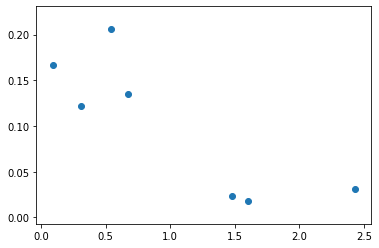

In [97]:
# zs_cat = [0.09, 0.31, 0.54, 0.67, 1.48, 2.43, 1.60]
# cat = [0.16655316444202306, 0.12158532639072751, 0.20617518023621312, 0.13494846656611362, 0.023252765338538678, 0.030717189077120333
# ,0.017620066922546994]

# plt.scatter(zs_cat,cat)

In [146]:
# def get_n(z):
#     if z >= 0.05 and z <= 0.15: 
#         return n1/7342 #0.17
#     if z >= 0.15 and z <= 0.43: #0.4
#         return n2/7554 #0.12
#     if z >= 0.44 and z <= 0.61: #0.47
#         return n3/8307 #0.21
#     if z >= 0.61 and z <= 0.81:
#         return n4/2210 #0.31
#     if z >= 0.68 and z <= 2.35:
#         return n5/5806 #0.023 
#     if z >= 2.20 and z <= 2.94:
#         return n6/8146 #0.03 
#     else:
#         return 0.023

In [147]:
# cat = []

# for i,z in enumerate(np.linspace(0, 4, 80)):
#     cat.append(get_n(z))

(0.001, 100.0)

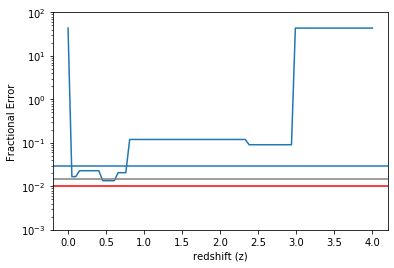

In [252]:
# plt.semilogy(np.linspace(0, 4, 80), 1/np.array(cat))
# plt.axhline(0.015, color = 'grey')
# plt.axhline(0.01, color = 'red')
# plt.axhline(0.03)

# plt.ylabel('Fractional Error')
# plt.xlabel('redshift (z)')
# plt.ylim(1e-3, 1e2)
# #plt.plot(zs, f(zs, -2.21713049,  16 , -34.52477968,  14.22135734,
#           #4.29919024))


In [268]:
# Lstar = 8.265
# alpha = 1.67

21502.591694129147

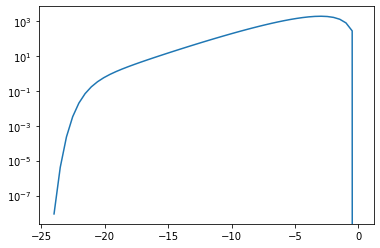

In [284]:
# def schechterL(luminosity, phiStar, alpha, LStar): 
#     """Schechter luminosity function.""" 
#     LOverLStar = (luminosity/LStar) 
#     return (phiStar/LStar) * LOverLStar**alpha * numpy.exp(- LOverLStar) 
 
# def schechterM(magnitude, phiStar, alpha, MStar): 
#     """Schechter luminosity function by magnitudes.""" 
#     MStarMinM = 0.4 * (MStar - magnitude) 
#     return (0.4 * np.log(10) * phiStar * 10.0**(MStarMinM * (alpha + 1.)) * np.exp(-10.**MStarMinM)) 

# MStar = -20.98 
# phiStar = 1.3e-3
# alpha = -1.73

# Ms = np.linspace(-24, 0)

# plt.semilogy(Ms, Ms**2 * schechterM(Ms, phiStar, alpha, MStar))

# np.trapz(Ms**2 * schechterM(Ms, phiStar, alpha, MStar))

In [222]:
# from scipy.optimize import curve_fit 

# def f(x, A, B, C, D, E):
#     return A*x**4 + B*x**3 + C*x**2 + D*x + E

# curve_fit(f, zs, 1/np.array(cat), [-2.3, 17.3, -31.65, 13.8, 4.3])



(array([ -2.21713049,  17.295551  , -34.52477968,  14.22135734,
          4.29919024]),
 array([[   0.66335826,   -5.32013315,   13.68120394,  -12.08749184,
            2.34312567],
        [  -5.32013315,   43.35335312, -113.84885866,  103.53449871,
          -20.95377285],
        [  13.68120394, -113.84885866,  307.69762487, -291.83261379,
           63.24076984],
        [ -12.08749184,  103.53449871, -291.83261379,  295.96587524,
          -72.71058798],
        [   2.34312567,  -20.95377285,   63.24076984,  -72.71058798,
           24.38268402]]))

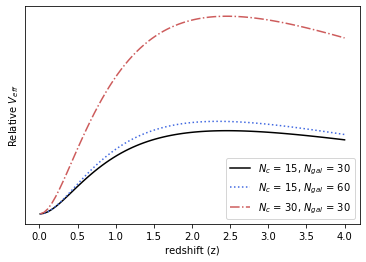

In [103]:
# zs_max = np.linspace(0.01, 4, 80)

# from astropy.cosmology import Planck15 as cosmoP


# plot3015_line, = plt.plot(zs_max, cosmoP.differential_comoving_volume(zs_max)*np.sqrt(1/frac_errors(np.linspace(0, 4, 80), 30, 15)[0])/10**12, color = 'black', label = '$N_c$ = 15, $N_{gal}$ = 30')
# plot6015_line, = plt.plot(zs_max, cosmoP.differential_comoving_volume(zs_max)*np.sqrt(1/frac_errors(np.linspace(0, 4, 80), 60, 15)[0])/10**12, color = 'royalblue', linestyle = 'dotted', label = '$N_c$ = 15, $N_{gal}$ = 60')
# plot3030_line, = plt.plot(zs_max, 2*cosmoP.differential_comoving_volume(zs_max)*np.sqrt(1/frac_errors(np.linspace(0, 4, 80), 30, 30)[0])/10**12, color = 'indianred', linestyle = '-.', label = '$N_c$ = 30, $N_{gal}$ = 30')
# #plot6060_line, = plt.plot(zs_max, 4*cosmoP.differential_comoving_volume(zs_max)*np.sqrt(1/frac_errors(np.linspace(0, 4, 80), 60, 60)[0])/10**12, color = 'royalblue', linestyle = '--', label = '$N_c$ = 15, N_{gal} = 30')

# plt.xlabel('redshift (z)')
# plt.ylabel('Relative $V_{eff}$')

# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left = False,
#     labelleft = False)

# plt.legend()
# plt.savefig('V_eff.pdf')

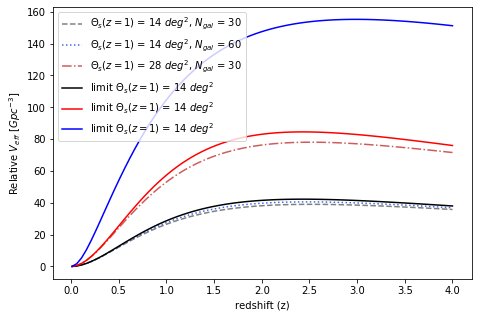

In [55]:
# zs_max = np.linspace(0.01, 4, 80)

# from astropy.cosmology import Planck15 as cosmoP


# plt.figure(figsize=(7.5,5))
# plot3015_line, = plt.plot(zs_max, cosmoP.differential_comoving_volume(zs_max)*np.sqrt(1/(1+1/shot_noise(theta_max(zs_max), 30)))/10**9, color = 'grey', label = '$\Theta_s(z=1)$ = 14 $deg^2$, $N_{gal}$ = 30', linestyle='dashed')
# plot6015_line, = plt.plot(zs_max, cosmoP.differential_comoving_volume(zs_max)*np.sqrt(1/(1+1/shot_noise(theta_max(zs_max), 60)))/10**9, color = 'royalblue', linestyle = 'dotted', label = '$\Theta_s(z=1)$ = 14 $deg^2$, $N_{gal}$ = 60')
# plot3030_line, = plt.plot(zs_max, 2*cosmoP.differential_comoving_volume(zs_max)*np.sqrt(1/(1+1/shot_noise(theta_max(zs_max), 30)))/10**9, color = 'indianred', linestyle = '-.', label = '$\Theta_s(z=1)$ = 28 $deg^2$, $N_{gal}$ = 30')
# #plot6060_line, = plt.plot(zs_max, 4*cosmoP.differential_comoving_volume(zs_max)*np.sqrt(1/frac_errors(np.linspace(0, 4, 80), 60, 60)[0])/10**12, color = 'royalblue', linestyle = '--', label = '$N_c$ = 15, N_{gal} = 30')

# plt.xlabel('redshift (z)')
# plt.ylabel('Relative $V_{eff}$ $[Gpc^{-3}]$')

# # plt.tick_params(
# #     axis='y',          # changes apply to the x-axis
# #     which='both',      # both major and minor ticks are affected
# #     left = False,
# #     labelleft = False)

# cosmic_var_line, = plt.plot(zs_max, cosmoP.differential_comoving_volume(zs_max)/10**9, color = 'black', label = 'limit $\Theta_s(z=1)$ = 14 $deg^2$')
# cosmic_var_line2, = plt.plot(zs_max, 2*cosmoP.differential_comoving_volume(zs_max)/10**9, color = 'red', label = 'limit $\Theta_s(z=1)$ = 14 $deg^2$')

# yi_kuan_line, = plt.plot(zs_max, 6*cosmoP.differential_comoving_volume(zs_max)*np.sqrt(1/(1+1/shot_noise(theta_max(zs_max), 3)))/10**9, color = 'blue', label = 'limit $\Theta_s(z=1)$ = 14 $deg^2$')



# plt.legend()
# #plt.savefig('V_eff_3.pdf')

In [53]:
# tot_err(cosmic_variance_error, shot_noise_error, n_fields)

array([4.15764112, 2.20602037, 1.55802255, 1.23586656, 1.04404634,
       0.91740662, 0.82802275, 0.76192571, 0.71135973, 0.67167382,
       0.6399033 , 0.61407081, 0.59280913, 0.5751423 , 0.56035218,
       0.54789949, 0.53737236, 0.52845073, 0.52088163, 0.51446202,
       0.50902751, 0.50444356, 0.500599  , 0.49740118, 0.49477236,
       0.49264667, 0.49096787, 0.48968761, 0.48876405, 0.48816116,
       0.48784786, 0.48779685, 0.48798398, 0.48838782, 0.48898927,
       0.48977127, 0.49071906, 0.49181952, 0.49306079, 0.4944321 ,
       0.4959236 , 0.49752631, 0.49923198, 0.50103328, 0.50292387,
       0.50489789, 0.50694992, 0.50907492, 0.5112682 , 0.51352538,
       0.51584236, 0.51821536, 0.52064113, 0.52311678, 0.52563955,
       0.52820684, 0.5308162 , 0.53346531, 0.53615196, 0.53887405,
       0.54162957, 0.54441673, 0.54723403, 0.55008007, 0.5529535 ,
       0.55585302, 0.55877739, 0.56172544, 0.564696  , 0.56768798,
       0.57070031, 0.57373197, 0.57678205, 0.5798498 , 0.58293

In [54]:
# for z in np.linspace(0.01, 2, 80):
#     print(frac_errors(z, 10, 15))

## Generate Fiducial Data

In [39]:
zs = np.linspace(0.01, 4, 80)


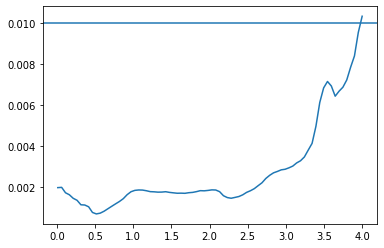

In [77]:
def frac_shot_error(depth = 1):
    survey_shot = np.load('frac_errors_survey.npy')
    return (1/depth)*survey_shot

plt.plot(zs, frac_shot_error(5))
plt.axhline(0.01)

In [54]:
def photo_z_error(A_n, zs):
    return A_n*(1+zs)**2

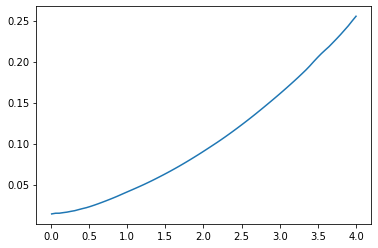

In [55]:
plt.plot(zs, np.sqrt(frac_shot_error()**2 + photo_z_error(0.01, zs)**2))

In [56]:
from scipy.stats import norm

def bias_error(sigma_z, alpha, zs):
    error = []

    for z0 in zs:
        weights = norm.pdf(zs, z0, sigma_z)
        error.append((np.average(zs, weights = (zs**alpha)*weights) - np.average(zs, weights = weights))/np.average(zs, weights = weights))
    return np.array(error)

0.20779153484333965

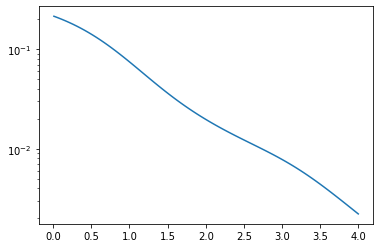

In [57]:
zs = np.linspace(0.01, 4, 80)
plt.semilogy(zs, bias_error(0.5, 0.3, zs))
np.max(bias_error(0.75, 0.3, zs))

In [58]:
def tot_frac_error(zs, model):
    if model == 1:
        print(model)
        A = np.sqrt(frac_shot_error()**2 + 0.01**2)
    if model == 2:
        A = np.sqrt(frac_shot_error()**2 + photo_z_error(0.01, zs)**2 + bias_error(0.025, 1, zs)**2)
    return A



In [69]:
tot_frac_error(zs, 1)

1


array([0.0140318 , 0.01407896, 0.01318554, 0.01287257, 0.01234749,
       0.01206897, 0.01149204, 0.01146501, 0.01126042, 0.01069499,
       0.01057394, 0.01063483, 0.01080239, 0.01104598, 0.01131556,
       0.01160542, 0.01190925, 0.01229417, 0.01288497, 0.01334899,
       0.01357211, 0.01363827, 0.01362043, 0.01351061, 0.01336464,
       0.01333679, 0.01328288, 0.01329406, 0.01335168, 0.01324375,
       0.01317413, 0.01310915, 0.0131212 , 0.01309921, 0.01319284,
       0.01324405, 0.0133654 , 0.01352378, 0.01349894, 0.01356478,
       0.01365488, 0.01363167, 0.01335944, 0.01272736, 0.01245279,
       0.01235541, 0.01247661, 0.01260665, 0.01286254, 0.01324426,
       0.01351084, 0.01385869, 0.01436988, 0.01488621, 0.01568303,
       0.01628283, 0.01676306, 0.01703638, 0.01735152, 0.01746764,
       0.01775575, 0.01811069, 0.01875715, 0.01920112, 0.01999859,
       0.0214607 , 0.02292485, 0.02673506, 0.0322047 , 0.03558514,
       0.03709289, 0.03603368, 0.03365183, 0.03481601, 0.03574

Text(0, 0.5, 'Fractional Error')

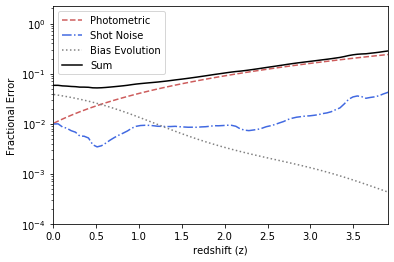

In [59]:
#shot_var_line, = plt.semilogy(np.linspace(0.05,4, 80), shot_noise_error/100, color = 'indianred', linestyle = 'dashed')

photo_z_line, = plt.semilogy(zs, photo_z_error(0.01, zs), color = 'indianred', linestyle = 'dashed', label = 'Photometric')
shot_z_line, = plt.semilogy(zs, frac_shot_error(), color = 'royalblue', linestyle = '-.', label = 'Shot Noise')
bias_z_line, = plt.semilogy(zs, bias_error(0.5, 0.05, zs), color = 'grey', linestyle =':', label = 'Bias Evolution')
#tot_z_line, = plt.semilogy(zs, tot_frac_error(zs), color = 'black', label = 'Total Fractional')
sum_z_line, = plt.semilogy(zs, photo_z_error(0.01, zs) + frac_shot_error() + bias_error(0.5, 0.05, zs), color = 'black', label = 'Sum')

plt.xlim(0, 3.9)
plt.ylim(1e-4, 2.2)
plt.legend()
plt.xlabel('redshift (z)')
plt.ylabel('Fractional Error')

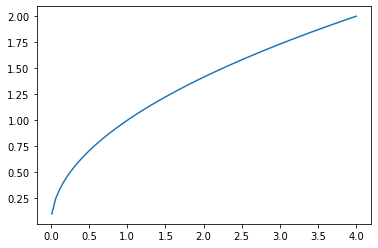

In [83]:
# from scipy.stats import norm

# def bias_evol_error(zs, sigma_z):
#     vals = []
#     for zz in zs:
#         vals.append(np.trapz((zz**0.5)*zz*norm.pdf(zz,zs,0.5),zs)/np.trapz(zz*norm.pdf(zz,zs, 0.5),zs))
#     return vals

# plt.plot(np.linspace(0.01, 4, 80), bias_evol_error(np.linspace(0.01, 4, 80), 0.05))

In [66]:
# np.trapz((zs**1.5)*zs*norm.pdf(zs,2,0.05),zs)/np.trapz(zs*norm.pdf(zs,2, 0.05),zs)

2.831741558257247

In [73]:
#def mk_data(theta, zmin = 0.1, zmax = 4, sample_size = 80, n_galaxies = 30, n_fields = 15):
def mk_data(theta, zmin = 0.01, zmax = 4, sample_size = 80, error_model = 1):  
    z_int_sampling = np.linspace(zmin, zmax, sample_size)
    sim_data = np.zeros((len(z_int_sampling), 3))
    error = np.zeros((len(z_int_sampling), 3))
    
    for i, z in enumerate(z_int_sampling):
        sim_data[i,:] = biased_weighted_emissivity_castor(theta, z)
        error[i,:] = sim_data[i,:]*tot_frac_error(zs, error_model)[i] #(z, n_galaxies, n_fields)
        #dJdzb_error = np.random.multivariate_normal(mean=np.array([0, 0, 0]), cov=np.diag(error[i,:]))
        #sim_data[i,:] = dJdzb + dJdzb_error

    return sim_data, error

sim_data, error = mk_data(theta, 0.01, 4, 80, 1)
#sim_data, error = mk_data(theta, 0.1, 2.2, 80)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [71]:
error

array([[7.60058734e+01, 1.13601499e+02, 1.52850658e+02],
       [1.06167828e+01, 1.56099555e+01, 2.07421645e+01],
       [3.36419488e+00, 4.86959699e+00, 6.39393263e+00],
       [1.91337948e+00, 2.72760149e+00, 3.54086586e+00],
       [1.51401337e+00, 2.12956556e+00, 2.73454009e+00],
       [1.43412701e+00, 1.98992480e+00, 2.52864930e+00],
       [1.44414119e+00, 1.98201914e+00, 2.49342969e+00],
       [1.52267699e+00, 2.07005027e+00, 2.57912685e+00],
       [1.61488373e+00, 2.17609485e+00, 2.68611935e+00],
       [1.70239800e+00, 2.28127572e+00, 2.79076530e+00],
       [1.80894674e+00, 2.42318313e+00, 2.93874928e+00],
       [1.91229365e+00, 2.58311629e+00, 3.10652614e+00],
       [1.94938005e+00, 2.75558066e+00, 3.28711610e+00],
       [2.08712367e+00, 2.93843275e+00, 3.47774294e+00],
       [2.14985965e+00, 3.12938796e+00, 3.67555876e+00],
       [2.18328286e+00, 3.32832194e+00, 3.88032424e+00],
       [2.19759848e+00, 3.53520142e+00, 4.09191516e+00],
       [2.19364477e+00, 3.75272

In [65]:
np.trapz(sim_data[:,0],zs)

90.00151909361463

In [66]:
1/(error[:,0])**2

array([1.73103438e-04, 8.87184888e-03, 8.83563382e-02, 2.73147844e-01,
       4.36255160e-01, 4.86210989e-01, 4.79491254e-01, 4.31304938e-01,
       3.83457715e-01, 3.45046638e-01, 3.05596544e-01, 2.73458126e-01,
       2.63152176e-01, 2.29563921e-01, 2.16361400e-01, 2.09787684e-01,
       2.07063385e-01, 2.07810458e-01, 2.11495091e-01, 2.23123608e-01,
       2.43590327e-01, 2.73529363e-01, 3.15407207e-01, 3.72926155e-01,
       4.54324603e-01, 5.78066849e-01, 6.88778685e-01, 1.06128278e+00,
       1.31901993e+00, 1.68505998e+00, 1.99758122e+00, 2.39898228e+00,
       2.90080715e+00, 3.49354495e+00, 4.32503021e+00, 5.24827541e+00,
       6.58993057e+00, 8.20931756e+00, 1.01200466e+01, 1.30817275e+01,
       1.64520673e+01, 2.11887747e+01, 2.49060526e+01, 3.01288744e+01,
       3.32790251e+01, 3.67531535e+01, 4.05387702e+01, 4.29030236e+01,
       4.55805266e+01, 4.74178625e+01, 4.95809729e+01, 5.18521734e+01,
       5.42095175e+01, 5.66956790e+01, 5.92716124e+01, 6.23353690e+01,
      

In [67]:
np.diag(np.array([1/np.array(error[0])**2, 1/np.array(error[1])**2, 1/np.array(error[2])**2]))

array([0.0001731 , 0.0041039 , 0.02446042])

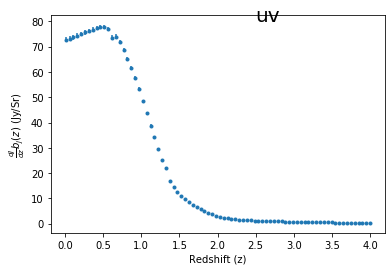

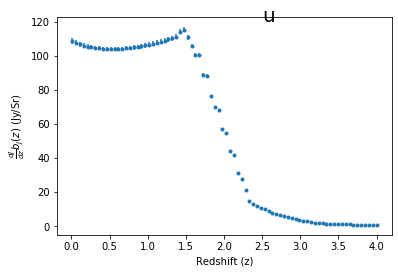

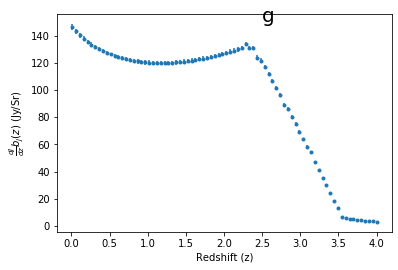

In [74]:
plt.errorbar(zs, sim_data[:,0], error[:,0], fmt = '.')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$\frac{dJ}{dz}b_j(z)$ (Jy/Sr)')
plt.text(2.5, 80, 'uv', fontsize='20')
plt.show()

plt.errorbar(zs, sim_data[:,1], error[:,1], fmt = '.')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$\frac{dJ}{dz}b_j(z)$ (Jy/Sr)')
plt.text(2.5, 120, 'u', fontsize='20')
plt.show()


plt.errorbar(zs, sim_data[:,2], error[:,2], fmt = '.')
plt.xlabel('Redshift (z)')
plt.ylabel(r'$\frac{dJ}{dz}b_j(z)$ (Jy/Sr)')
plt.text(2.5, 150, 'g', fontsize='20')
plt.show()

## Monopoles

In [61]:
# need b(z) at effective center of filter
# for now, using 
# 0.230 um uv???
# 0.374 μm u
# 0.487 μm g

speed_of_light_um = 3*10**14
nu_uv = speed_of_light_um/0.230
nu_u = speed_of_light_um/0.374
nu_g = speed_of_light_um/0.487

In [62]:
def b2(L_bar, z): 
    return 0.32*(L_bar/1500)**0.86 * (1 + z)**(0.79)

In [63]:
(1539/1500)**0.86

1.0223197013655134

In [64]:
zs = np.linspace(0, 4.0, 80)

(0, 3.5)

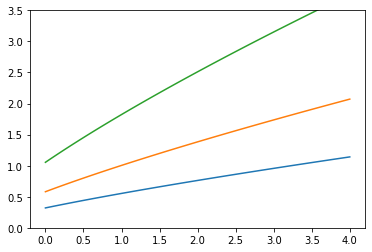

In [65]:
plt.plot(zs, b2(1500, zs))
plt.plot(zs, b2(3000, zs))
plt.plot(zs, b2(6000, zs))
plt.ylim([0,3.5])

In [66]:
b_z_uv = b2(2300, 0)
b_z_u = b2(3740, 0)
b_z_g = b2(4870, 0)

In [67]:
sim_data[:,0]

array([73.64819301, 74.22195907, 74.82957198, 75.45444144, 76.0759098 ,
       76.66643111, 77.18491223, 77.56915759, 77.72704574, 77.40502853,
       76.46711366, 75.01512655, 72.94618317, 70.35203346, 63.71857518,
       60.13099264, 59.92700574, 55.93118221, 51.43496746, 46.70095632,
       41.9634979 , 37.30548738, 32.76804174, 28.43962011, 23.89868819,
       19.69099307, 16.44509814, 13.99139736, 12.22551676, 10.81831453,
        9.53132926,  8.36466651,  7.32165438,  6.39620817,  5.61610134,
        4.88931343,  4.2382428 ,  3.66898546,  3.16316276,  2.70977673,
        2.34525492,  2.06872876,  1.85527952,  1.68323801,  1.55148997,
        1.44540583,  1.35263628,  1.27113013,  1.20839743,  1.14921672,
        1.09334   ,  1.04053526,  0.99311717,  0.94572513,  0.900815  ,
        0.85822173,  0.81779591,  0.77940746,  0.74293503,  0.7082302 ,
        0.67513391,  0.64350559,  0.61323582,  0.58423854,  0.55650989,
        0.53012568,  0.50500824,  0.48107664,  0.45825046,  0.43

(0, 400)

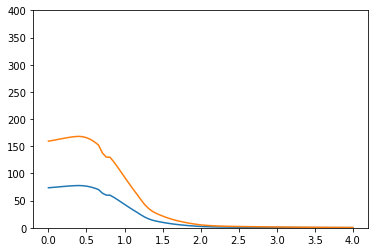

In [68]:
plt.plot(zs, sim_data[:,0])
plt.plot(zs, sim_data[:,0]/b_z_uv)
plt.ylim([0,400])

In [69]:
print(sim_data[:,0]/b_z_uv)
print(sim_data[:,1]/b_z_u)
print(sim_data[:,2]/b_z_g)

[159.3546208  160.59609421 161.91080297 163.2628502  164.60753839
 165.88526559 167.00711744 167.83851969 168.18014662 167.48338914
 165.45399693 162.31229248 157.83566279 152.22262972 137.8696336
 130.10708258 129.66571051 121.01983725 111.29125373 101.04814362
  90.79757454  80.71890906  70.90111315  61.53558823  51.71024894
  42.60594328  35.58271115  30.27357128  26.45268686  23.40788469
  20.62319926  18.09885899  15.84206496  13.83965154  12.15171293
  10.57914194   9.1704025    7.93868476   6.84422227   5.86321843
   5.07449258   4.47616531   4.01431931   3.64206837   3.35700153
   3.12746435   2.92673631   2.75037922   2.61464276   2.48659183
   2.36568984   2.25143476   2.14883493   2.04629147   1.94911818
   1.85695796   1.76948749   1.68642536   1.60750896   1.53241716
   1.46080582   1.39237074   1.32687522   1.264133     1.20413575
   1.14704752   1.09270023   1.04091876   0.99152913   0.94437301
   0.90139337   0.857899     0.8158607    0.77472304   0.73738344
   0.705104

In [66]:
np.trapz(sim_data[:,0]/b_z_uv, zs)

184.44614631453388

In [67]:
np.trapz(sim_data[:,1]/b_z_u, zs)

309.8860188782113

In [68]:
np.trapz(sim_data[:,2]/b_z_g, zs)

430.99387558173214

In [69]:
fractional_errors_z = frac_errors(zs, 30, 15)

In [70]:
np.sqrt(np.sum(fractional_errors_z[:,2]**2))

0.20319922473412103

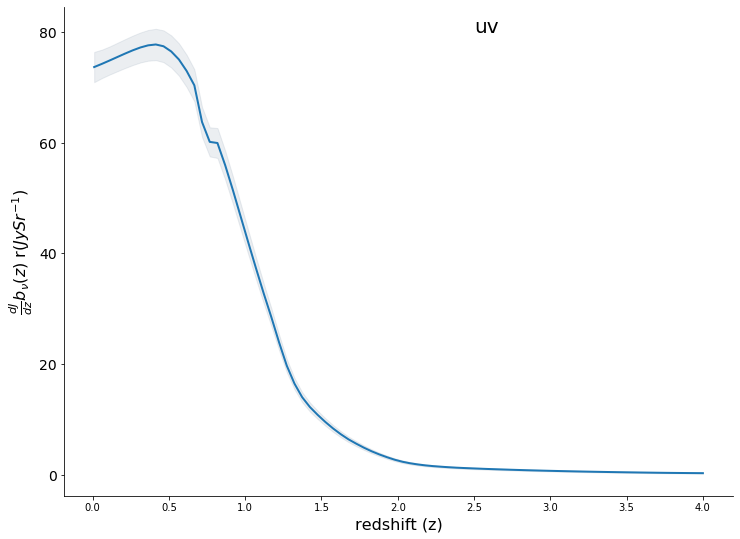

In [128]:
# You typically want your plot to be ~1.33x wider than tall.  
# Common sizes: (10, 7.5) and (12, 9)  
plt.figure(figsize=(12, 9))  
  
# Remove the plot frame lines. They are unnecessary chartjunk.  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.  
# Ticks on the right and top of the plot are generally unnecessary chartjunk.  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# Limit the range of the plot to only where the data is.  
# Avoid unnecessary whitespace.  
#plt.ylim(63, 85)  
  
# Make sure your axis ticks are large enough to be easily read.  
# You don't want your viewers squinting to read your plot.  
#plt.xticks(range(0, 4, 20), fontsize=14)  
plt.yticks(range(0, 100, 20), fontsize=14)  
plt.text(2.5, 80, 'uv', fontsize='20')
  
# Along the same vein, make sure your axis labels are large  
# enough to be easily read as well. Make them slightly larger  
# than your axis tick labels so they stand out.  
plt.ylabel(r"$\frac{dJ}{dz}b_{\nu}(z)$ r$(Jy Sr^{-1})$", fontsize=16) 
plt.xlabel(r"redshift (z)", fontsize = 16)
  
# Use matplotlib's fill_between() call to create error bars.  
# Use the dark blue "#3F5D7D" as a nice fill color.  
plt.fill_between(zs, sim_data[:,0] - error[:,0],  
                 sim_data[:,0] + error[:,0], color="#3F5D7D", alpha = 0.1)  
  
# Plot the means as a white line in between the error bars.   
# White stands out best against the dark blue.  
plt.plot(zs, sim_data[:,0],  lw=2)  

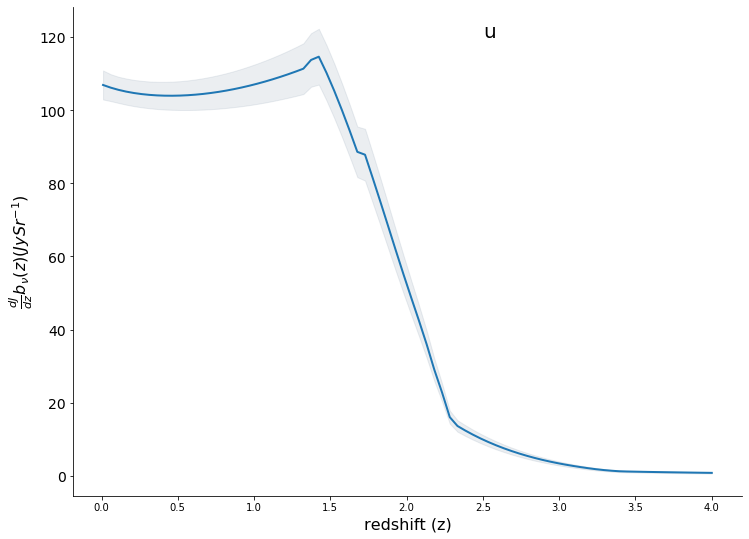

In [129]:
# You typically want your plot to be ~1.33x wider than tall.  
# Common sizes: (10, 7.5) and (12, 9)  
plt.figure(figsize=(12, 9))  
  
# Remove the plot frame lines. They are unnecessary chartjunk.  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.  
# Ticks on the right and top of the plot are generally unnecessary chartjunk.  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# Limit the range of the plot to only where the data is.  
# Avoid unnecessary whitespace.  
#plt.ylim(63, 85)  
  
# Make sure your axis ticks are large enough to be easily read.  
# You don't want your viewers squinting to read your plot.  
#plt.xticks(range(0, 4, 20), fontsize=14)  
plt.yticks(range(0, 145, 20), fontsize=14)  
plt.text(2.5, 120, 'u', fontsize='20')
  
# Along the same vein, make sure your axis labels are large  
# enough to be easily read as well. Make them slightly larger  
# than your axis tick labels so they stand out.  
plt.ylabel(r"$\frac{dJ}{dz}b_{\nu}(z) (Jy Sr^{-1})$", fontsize=16) 
plt.xlabel(r"redshift (z)", fontsize = 16)
  
# Use matplotlib's fill_between() call to create error bars.  
# Use the dark blue "#3F5D7D" as a nice fill color.  
plt.fill_between(zs, sim_data[:,1] - error[:,1],  
                 sim_data[:,1] + error[:,1], color="#3F5D7D", alpha = 0.1)  
  
# Plot the means as a white line in between the error bars.   
# White stands out best against the dark blue.  
plt.plot(zs, sim_data[:,1], lw=2)  

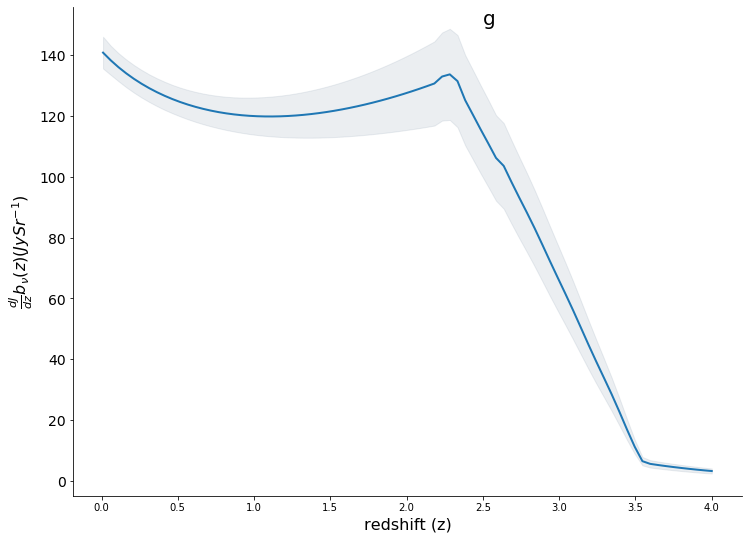

In [130]:
# You typically want your plot to be ~1.33x wider than tall.  
# Common sizes: (10, 7.5) and (12, 9)  
plt.figure(figsize=(12, 9))  
  
# Remove the plot frame lines. They are unnecessary chartjunk.  
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.  
# Ticks on the right and top of the plot are generally unnecessary chartjunk.  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# Limit the range of the plot to only where the data is.  
# Avoid unnecessary whitespace.  
#plt.ylim(63, 85)  
  
# Make sure your axis ticks are large enough to be easily read.  
# You don't want your viewers squinting to read your plot.  
#plt.xticks(range(0, 4, 20), fontsize=14)  
plt.yticks(range(0, 180, 20), fontsize=14)  
plt.xlabel(r"redshift (z)", fontsize = 16)
  
# Along the same vein, make sure your axis labels are large  
# enough to be easily read as well. Make them slightly larger  
# than your axis tick labels so they stand out.  
plt.ylabel(r"$\frac{dJ}{dz}b_{\nu}(z) (Jy Sr^{-1})$", fontsize=16) 
plt.text(2.5, 150, 'g', fontsize='20')
  
# Use matplotlib's fill_between() call to create error bars.  
# Use the dark blue "#3F5D7D" as a nice fill color.  
plt.fill_between(zs, sim_data[:,2] - error[:,2],  
                 sim_data[:,2] + error[:,2], color="#3F5D7D", alpha = 0.1)  
  
# Plot the means as a white line in between the error bars.   
# White stands out best against the dark blue.  
plt.plot(zs, sim_data[:,2], lw=2)  

In [74]:
# def theta_max(z):
#     ang_dist = cosmo.angularDiameterDistance(z) #Mpc/h
#     #return 1 * (np.pi/180)
#     return 5/ang_dist 

# def geometric_factor(z):
#     redshift_bin_ratio = 1 #in principle depends on choices of redshift binning, see Menard (2013)
#     return theta_max(z)*np.sqrt(np.pi)*(redshift_bin_ratio)

# def w_variance(n, deltaJ, z):
#     return (1/n) * (1/deltaJ) *geometric_factor(z)

# def sigma_dm(z, sigma_a = 0.069, sigma_b = 0.234, Beta = 0.834): 
#     return sigma_a/(z**Beta + sigma_b)

# def sigma_dm_bz(z, sigma_a = 0.069, sigma_b = 0.234, Beta = 0.834, gammabz = 0.79):
#     return (1+z)**(gammabz) * sigma_dm(z, sigma_a, sigma_b, Beta)**2

# def bias(z, b0 = 0.173, b1 = 2.89, b2 = 1.438): 
#     return b0*(z + 1)**b1 + b2

# def sigma_dm_br_bz(z, b0 = 0.173, b1 = 2.89, b2 = 1.438, sigma_a = 0.069, sigma_b = 0.234, Beta = 0.834, gammabz = 0.79):
#     return bias(z, b0, b1, b2)*sigma_dm_bz(z, sigma_a, sigma_b, Beta, gammabz)

# def tot_error(zs):
#     return np.sqrt(geometric_factor(zs)**2 + (sigma_dm_br_bz(zs))**2 + (np.ones(1)*0.01)**2)

In [75]:
# def mk_data(theta, zmin = 0.1, zmax = 4, sample_size = 100):
#     z_int_sampling = np.linspace(zmin, zmax, sample_size)
#     sim_data = np.zeros((len(z_int_sampling), 2))
#     error = np.zeros((len(z_int_sampling), 2))
#     for i, z in enumerate(z_int_sampling):
#         dJdzb = [biased_weighted_emissivity_fuv(theta, z), biased_weighted_emissivity_castor(theta, z)]
#         dJdzb_error = np.random.multivariate_normal(mean=np.array([0, 0]), cov=np.diag(tot_error(z)*dJdzb))
#         sim_data[i, :] = dJdzb + dJdzb_error
#         error[i, :] = (tot_error(z)*dJdzb)
#     return sim_data, error 

# sim_data, error = mk_data(theta, 0.1, 2, 80)

In [76]:
# plt.errorbar(zs, 300*sim_data[:,0]/10**23, 300*error[:,0]/10**23, fmt = '.')

In [77]:
# plt.errorbar(zs, 300*sim_data[:,1]/10**23, 300*error[:,1]/10**23, fmt = '.')

# Section 5: Emcee sampling to recover parameters

Define prior, likelihood and posterior for sampling
Note: These assume 3xN data vectors

In [78]:
def lnprior(theta):
    """Returns (log) prior on the model parameters. Uniform within the uncertainties quoted in Chiang(2019), 0 elsewhere."""
    log_e1500z0_b1500z0, gammae1500, alpha1500z0, Calpha1500, alpha1100z0, Calpha1100, EWLyAz03, EWLyAz1, gammabnu, gammabz, logfLyCz2, logfLyCz2 = theta
    
    #uniform priors on all parameters

    condlist = [25.12<log_e1500z0_b1500z0<25.14, (2.06-0.30)<gammae1500<(2.06+0.31),
               -0.08 - 0.84<alpha1500z0<-0.84+1.28, 1.85-1.28<Calpha1500<1.85+1.22,
               -3.71 - 0.98<alpha1100z0<-3.71 + 1.34, 0.50 - 1.44<Calpha1100<0.50+1.46,
               -6.17 - 11.43 <EWLyAz03 < -6.17 + 12.63, 88.02 - 48.87 < EWLyAz1 < 88.02 + 51.44, 
                logfLyCz1 <= 0.0, logfLyCz2 <= 0.0, 
               -0.86 - 1.29 <gammabnu<-0.86 + 0.83, 0.79 - 0.33 <gammabz < 0.79 + 0.32]
    
    if all(condlist):
        return 0.0
    return -np.inf

# def lnlike_parallel(theta, z, datum, datum_error):
#     """
#     Returns likelihood for a given datum, e.g. a 3D vector of observed biased-weighted emissivities from the set 
#     of all data. This function is appropriate to the parallelized posterior function. 
#     """
#     diff = new_model(theta, z) - datum
#     icov = np.diag(np.array([1/datum_error[0], 1/datum_error[1], 1/datum_error[2]]))
    
#     return -0.5* (np.dot(np.transpose(diff), np.dot(icov, diff)))


def lnlike_parallel(theta, z, datum, datum_error):
    """
    Returns likelihood for a given datum, e.g. a 3D vector of observed biased-weighted emissivities from the set 
    of all data. This function is appropriate to the parallelized posterior function. 
    """
    diff = model(theta, z) - datum
    icov = np.diag(np.array([1/np.array(datum_error[0])**2, 1/np.array(datum_error[1])**2, 1/np.array(datum_error[2])**2]))
    
    return -0.5* (np.dot(np.transpose(diff), np.dot(icov, diff)))



def lnprob_parallel(theta, zs, data):
    """
    Returns the (log) posterior of the model parameters conditioned on the data for a given prior. 
    Requires a 3xN data array and a vector of length N which specifies the redshift sampling.
    This function is for use with the parallelized emcee sampling. 
    """
    lp = lnprior(theta)
    #pool = mp.Pool(mp.cpu_count())
    
    lks = np.zeros(len(zs))
    
    for i, (z, datum, datum_error) in enumerate(zip(zs, data[0], data[1])):
        lks[i] = lnlike_parallel(theta, z, datum, datum_error)
    lksum = np.sum(lks)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(lksum):
        return -np.inf
    return lp + lksum

# Section 6: Running Sampler

In [79]:
# def main():
#     print('Starting emcee sampling')
#     nwalkers = 100
#     ndim = len(theta)
#     n_samps = 4000
#     chain_len = 100
#     zmax = 4
#     zmin = 0.01
#     zs = np.linspace(zmin,zmax, n_samps) #define redshift sampling
#     print('nwalkers, ndim, n_samps, chain_len, min(zs), max(zs)')
#     print([nwalkers, ndim, n_samps, chain_len, min(zs), max(zs)])
    
#     print('Initializing Walkers')

#     p0 = theta + 1e-3 * np.random.randn(nwalkers, len(theta))
    
#     print('Making data')

#     data = mk_data(theta, zmin = zmin, zmax = zmax, sample_size = n_samps)
    
#     print(np.min(data[0]), np.max(data[0]), np.mean(data[0]), np.min(data[1]), np.max(data[1]), np.mean(data[1]))
    
#     from multiprocess import cpu_count

#     ncpu = cpu_count()
#     print("{0} CPUs".format(ncpu))
    
# #     filename = "/rhome/bscot002/bigdata/newrun.h5"
# #     backend = emcee.backends.HDFBackend(filename)
# #     backend.reset(nwalkers, ndim)

#     with Pool() as pool: 
#         sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_parallel2, args = [zs, data], pool=pool, backend = backend)
#         start = time.time()
#         pos, prob, state = sampler.run_mcmc(p0, chain_len, progress = True)
#         end = time.time()
#         multi_time = end - start
#         print("Multiprocessing took {0:.1f} seconds".format(multi_time))
        
#     tau = sampler.get_autocorr_time()
#     print('sampling complete')
#     print('tau is:')
#     print(tau)
    
#     flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
#     print(flat_samples.shape)
    
    

#     fig = corner.corner(flat_samples);
    
#     fig.savefig(path+'corner_test.png')
        
#     pass

# if __name__ == "__main__":
#     main()

burn-in: 270
thin: 65
flat chain shape: (153400, 11)
flat log prob shape: (153400,)


NameError: name 'plt' is not defined

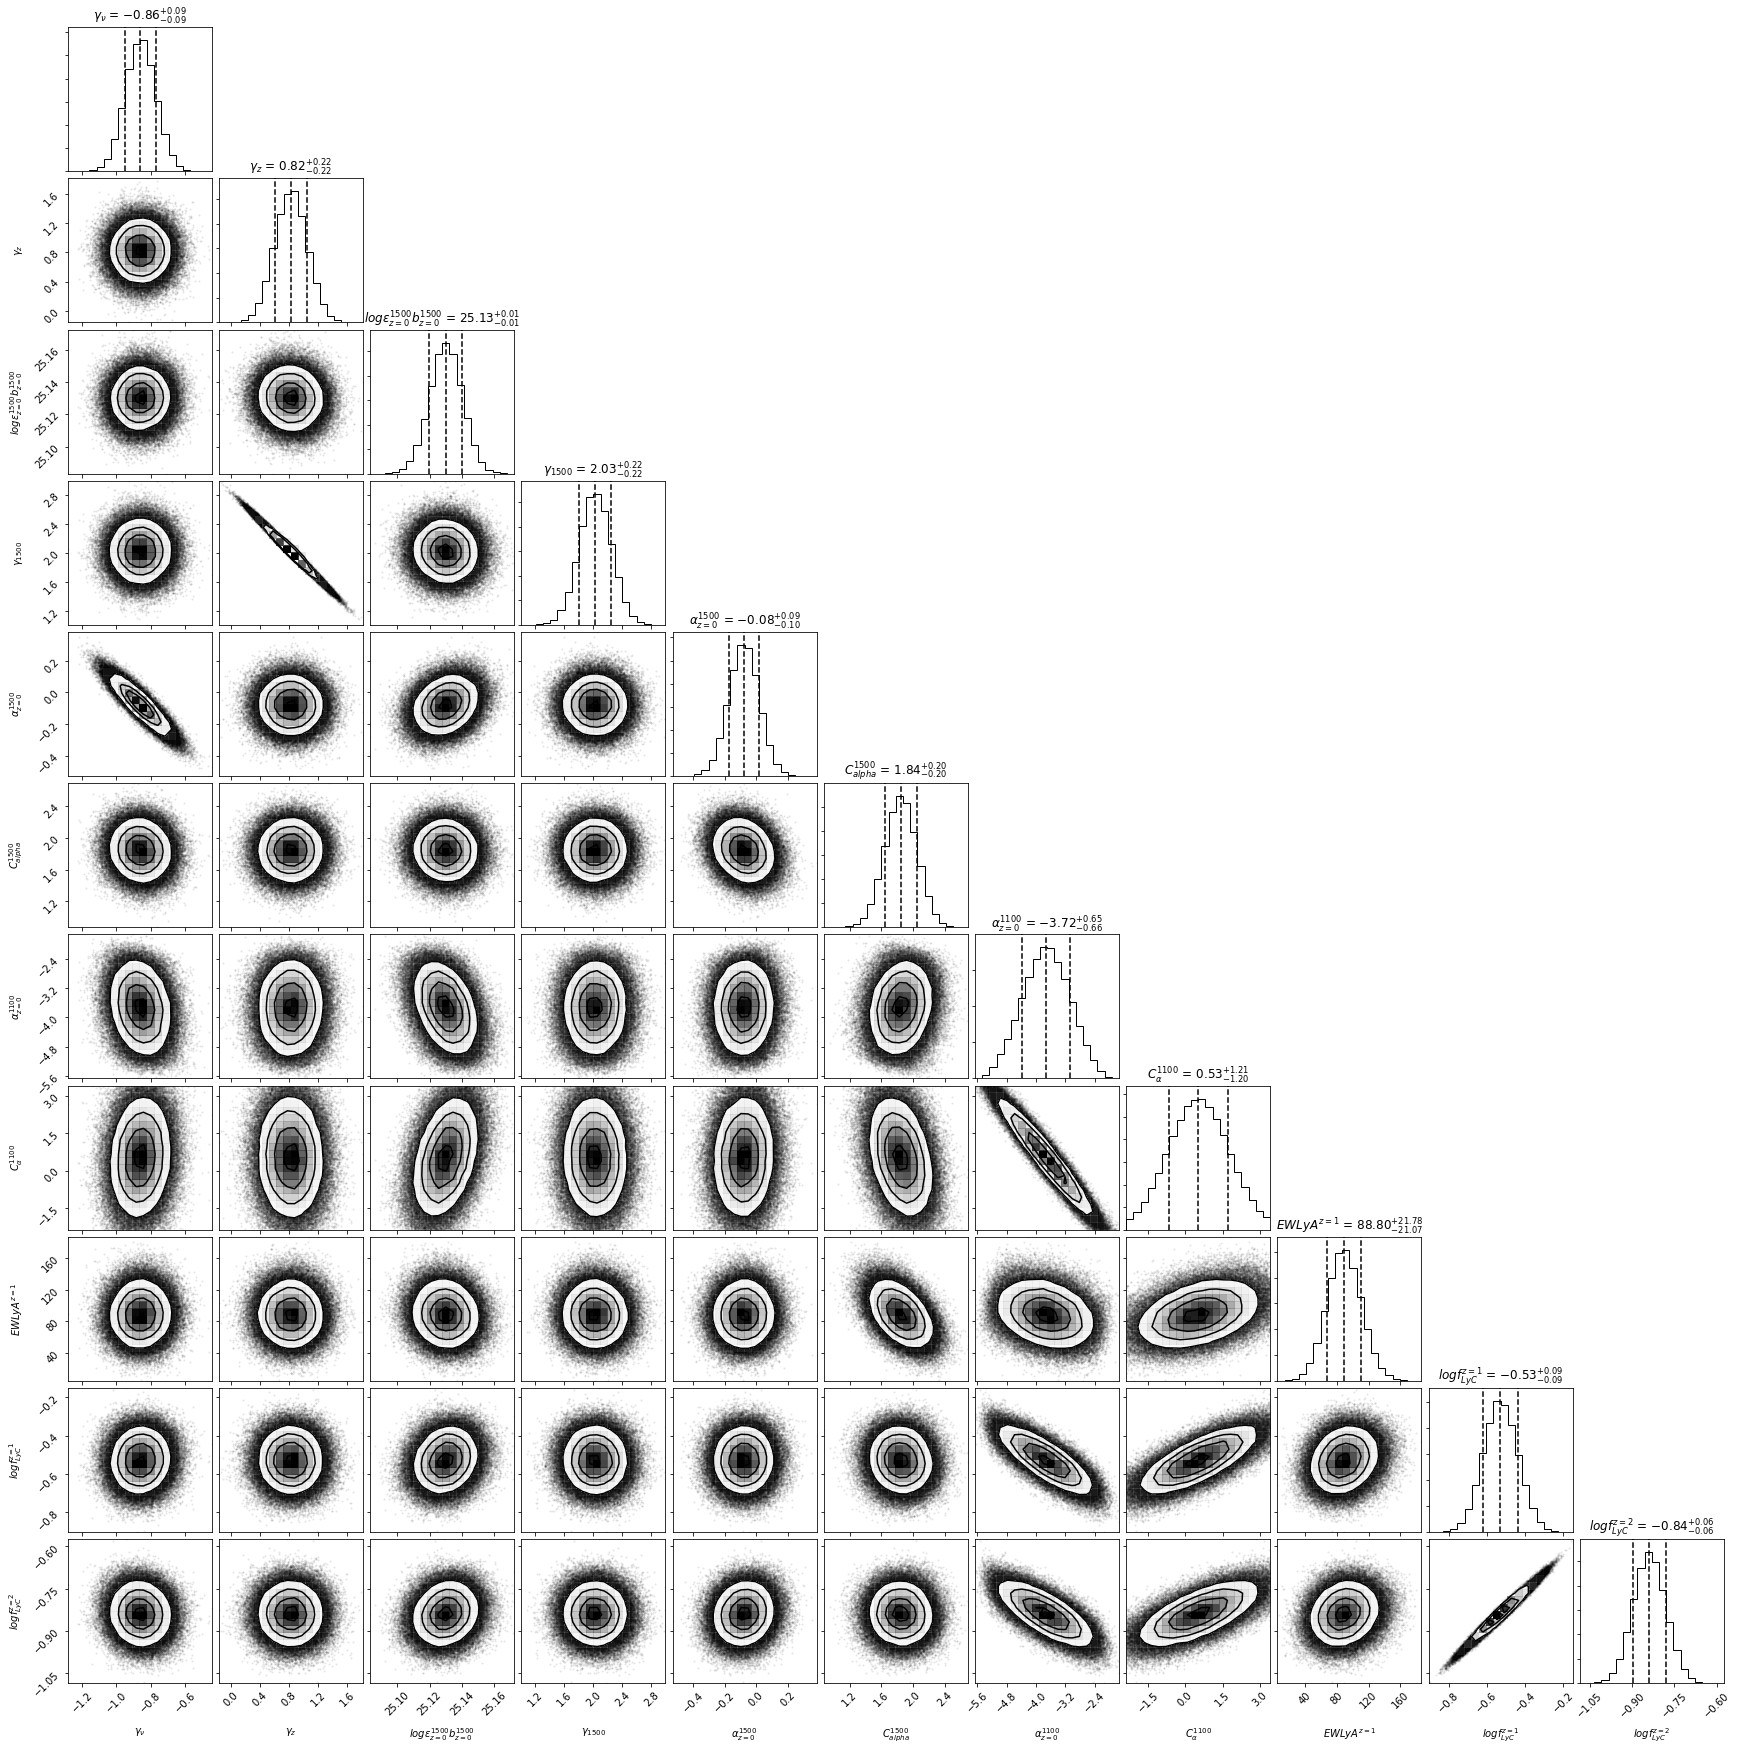

In [2]:
import numpy as np
import emcee

reader = emcee.backends.HDFBackend('run_82_three_priors_30.h5')

tau = reader.get_autocorr_time()
#tau = [449.76694998, 442.67813484, 413.36937586, 406.50812009, 450.02532561,
#       419.1535465,  410.66894801, 453.78044351, 417.92049071, 426.10807392,
#       409.79140682, 599.26860775]
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
#log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
#print("flat log prior shape: {0}".format(log_prior_samples.shape))

import corner

ndim = 12

# all_samples = np.concatenate(
#     (samples, log_prob_samples[:, None]), axis=1
# )

labels = [r'$\gamma_{\nu}$', r'$\gamma_{z}$', r'$log \epsilon^{1500}_{z=0} b^{1500}_{z=0}$', r'$\gamma_{1500}$', r'$\alpha^{1500}_{z=0}$', r'$C_{alpha}^{1500}$', r'$\alpha^{1100}_{z=0}$', 
          r'$C_{\alpha}^{1100}$', r'$EWLyA^{z=1}$',  r'$log f_{LyC}^{z=1}$', r'$log f_{LyC}^{z=2}$']

#truths = theta

# labels = list(map(r"$\theta_{{{0}}}$".format, range(1, ndim + 1)))
# labels += ["log prob", "log prior"]

#print(np.shape(all_samples))

#corner.corner(all_samples, labels=labels);

corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})


plt.savefig('test_final_corner_plot.pdf')

In [81]:
np.shape(samples)

(48600, 11)

In [82]:
sub_samples = samples[::100,:]

In [83]:
# for i in range(len(sub_samples)):
#     plt.plot(zs, biased_weighted_emissivity_fuv(sub_samples[i, :], zs))

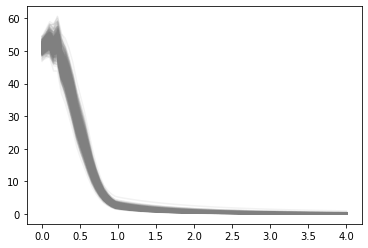

In [84]:
zs = np.linspace(0.0, 4.0, 80)

dJdz_b = np.zeros(len(zs))

for j in range(len(sub_samples)):
    for i, z in enumerate(zs):
        dJdz_b[i] = biased_weighted_emissivity_fuv(sub_samples[j, :], z)
    
    plt.plot(zs, dJdz_b, color = 'grey', alpha = 0.1)

In [85]:
# zs = np.linspace(0.0, 4.0, 80)

# dJdz_b_uv = np.zeros(len(zs))
# EBL_uv = np.zeros(len(sub_samples))

# for j in range(len(sub_samples)):
#     for i, z in enumerate(zs):
#         dJdz_b_uv[i] = biased_weighted_emissivity_castor_2(sub_samples[j, :], z)[0]
#     EBL_uv[j] = np.trapz(dJdz_b_uv, zs)
    
#     plt.plot(zs, dJdz_b_uv, color = 'grey', alpha = 0.1)
    
# plt.text(3.0, 200, np.mean(np.round(EBL_uv)))
# plt.show()

# dJdz_b_u = np.zeros(len(zs))
# EBL_u = np.zeros(len(sub_samples))

# for j in range(len(sub_samples)):
#     for i, z in enumerate(zs):
#         dJdz_b_u[i] = biased_weighted_emissivity_castor_2(sub_samples[j, :], z)[1]
#     EBL_u[j] = np.trapz(dJdz_b_u, zs)
    
#     plt.plot(zs, dJdz_b_u, color = 'grey', alpha = 0.1)

# plt.text(3.0, 250, np.mean(np.round(EBL_u)))
# plt.show()

# dJdz_b_g = np.zeros(len(zs))
# EBL_g = np.zeros(len(sub_samples))

# for j in range(len(sub_samples)):
#     for i, z in enumerate(zs):
#         dJdz_b_g[i] = biased_weighted_emissivity_castor_2(sub_samples[j, :], z)[2]
#     EBL_g[j] = np.trapz(dJdz_b_g, zs)
    
#     plt.plot(zs, dJdz_b_g, color = 'grey', alpha = 0.1)

# plt.text(3.0, 300, np.mean(np.round(EBL_g)))
# plt.show()

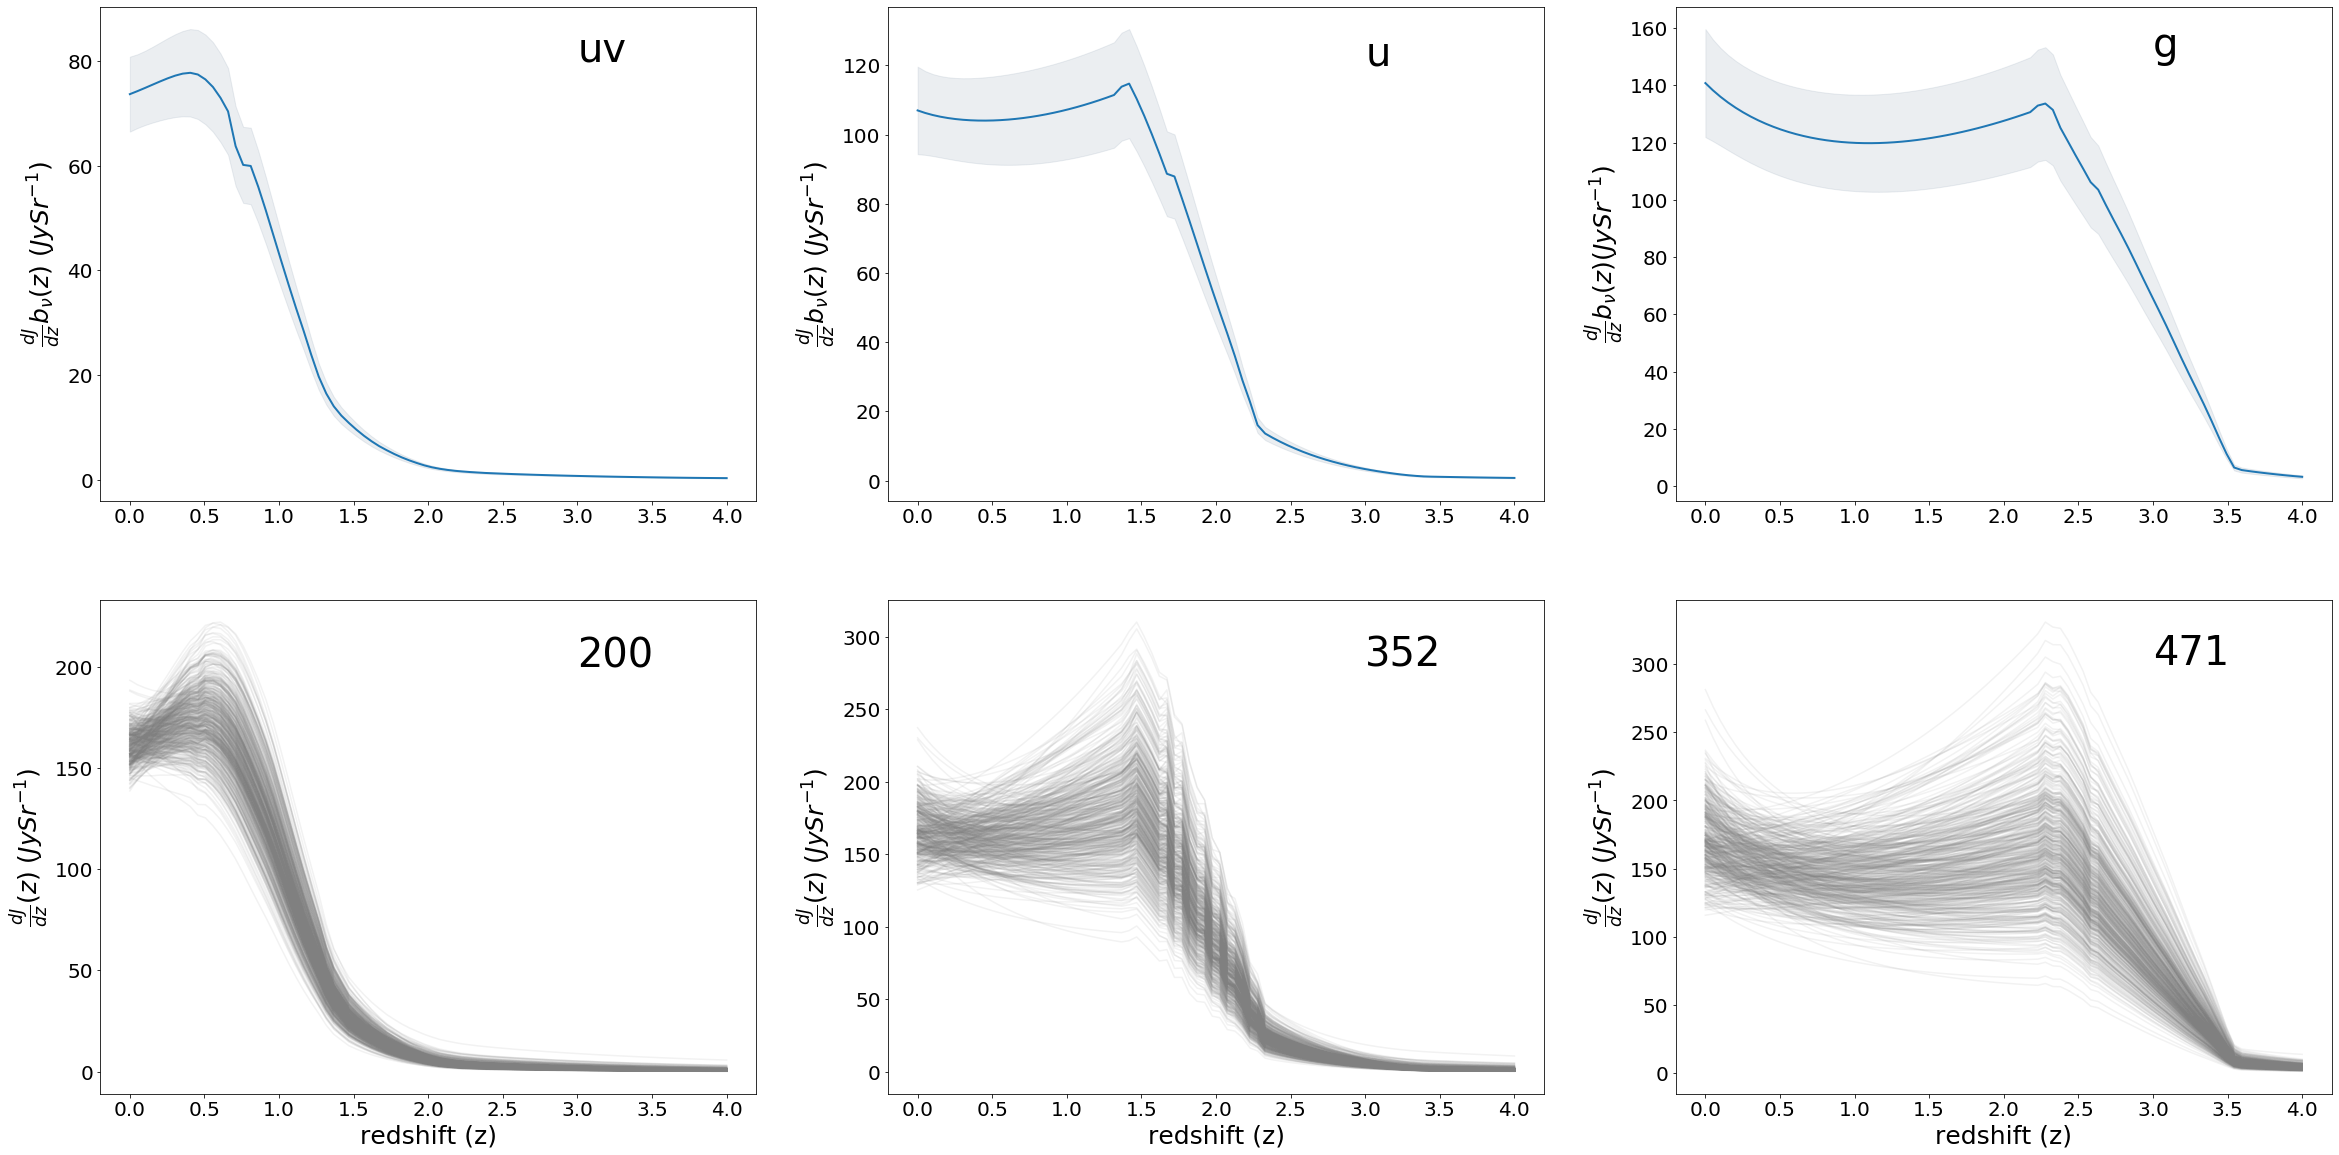

In [86]:
fig, axs = plt.subplots(2, 3)

fig.set_figheight(20)
fig.set_figwidth(40)

# You typically want your plot to be ~1.33x wider than tall.  
# Common sizes: (10, 7.5) and (12, 9)  
  
# # Remove the plot frame lines. They are unnecessary chartjunk.   
# axs[0,2].spines["top"].set_visible(False)  
# axs[0,2].spines["right"].set_visible(False)  
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.  
# Ticks on the right and top of the plot are generally unnecessary chartjunk.  
axs[0,2].get_xaxis().tick_bottom()  
axs[0,2].get_yaxis().tick_left()  
  
# Limit the range of the plot to only where the data is.  
# Avoid unnecessary whitespace.  
#plt.ylim(63, 85)  
  
# Make sure your axis ticks are large enough to be easily read.  
# You don't want your viewers squinting to read your plot.  
#plt.xticks(range(0, 4, 20), fontsize=14)  
axs[0,2].set_yticks(range(0, 180, 20))  
#axs[0,2].set_xlabel(r"redshift (z)", fontsize = 16)
  
# Along the same vein, make sure your axis labels are large  
# enough to be easily read as well. Make them slightly larger  
# than your axis tick labels so they stand out.  
axs[0,2].set_ylabel(r"$\frac{dJ}{dz}b_{\nu}(z) (Jy Sr^{-1})$", fontsize=25) 
axs[0,2].text(3.0, 150, 'g', fontsize='40')
  
# Use matplotlib's fill_between() call to create error bars.  
# Use the dark blue "#3F5D7D" as a nice fill color.  
axs[0,2].fill_between(zs, sim_data[:,2] - error[:,2],  
                 sim_data[:,2] + error[:,2], color="#3F5D7D", alpha = 0.1)  
  
# Plot the means as a white line in between the error bars.   
# White stands out best against the dark blue.  
axs[0,2].plot(zs, sim_data[:,2], lw=2)  


# # Remove the plot frame lines. They are unnecessary chartjunk.  
# axs[0,0].spines["top"].set_visible(False)  
# axs[0,0].spines["right"].set_visible(False)  
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.  
# Ticks on the right and top of the plot are generally unnecessary chartjunk.  
axs[0,0].get_xaxis().tick_bottom()  
axs[0,0].get_yaxis().tick_left()  
  
# Limit the range of the plot to only where the data is.  
# Avoid unnecessary whitespace.  
#plt.ylim(63, 85)  
  
# Make sure your axis ticks are large enough to be easily read.  
# You don't want your viewers squinting to read your plot.  
#plt.xticks(range(0, 4, 20), fontsize=14)  
axs[0,0].set_yticks(range(0, 100, 20))  
axs[0,0].text(3.0, 80, 'uv', fontsize='40')
  
# Along the same vein, make sure your axis labels are large  
# enough to be easily read as well. Make them slightly larger  
# than your axis tick labels so they stand out.  
axs[0,0].set_ylabel(r"$\frac{dJ}{dz}b_{\nu}(z)$ $(Jy Sr^{-1})$", fontsize=25) 
#axs[0,0].set_xlabel(r"redshift (z)", fontsize = 16)
  
# Use matplotlib's fill_between() call to create error bars.  
# Use the dark blue "#3F5D7D" as a nice fill color.  
axs[0,0].fill_between(zs, sim_data[:,0] - error[:,0],  
                 sim_data[:,0] + error[:,0], color="#3F5D7D", alpha = 0.1)  
  
# Plot the means as a white line in between the error bars.   
# White stands out best against the dark blue.  
axs[0,0].plot(zs, sim_data[:,0],  lw=2)  


# # Remove the plot frame lines. They are unnecessary chartjunk.  
# axs[0,0].spines["top"].set_visible(False)  
# axs[0,0].spines["right"].set_visible(False)  
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.  
# Ticks on the right and top of the plot are generally unnecessary chartjunk.  
axs[0,1].get_xaxis().tick_bottom()  
axs[0,1].get_yaxis().tick_left()  
  
# Limit the range of the plot to only where the data is.  
# Avoid unnecessary whitespace.  
#plt.ylim(63, 85)  
  
# Make sure your axis ticks are large enough to be easily read.  
# You don't want your viewers squinting to read your plot.  
#plt.xticks(range(0, 4, 20), fontsize=14)  
# axs[0,1].set_yticks(range(0, 100, 20))  
# axs[0,1].text(2.5, 80, 'uv', fontsize='20')

axs[0,1].set_yticks(range(0, 145, 20))  
axs[0,1].text(3.0, 120, 'u', fontsize='40')
  
# Along the same vein, make sure your axis labels are large  
# enough to be easily read as well. Make them slightly larger  
# than your axis tick labels so they stand out.  
axs[0,1].set_ylabel(r"$\frac{dJ}{dz}b_{\nu}(z)$ $(Jy Sr^{-1})$", fontsize=25) 
  
# Use matplotlib's fill_between() call to create error bars.  
# Use the dark blue "#3F5D7D" as a nice fill color.  
axs[0,1].fill_between(zs, sim_data[:,1] - error[:,1],  
                 sim_data[:,1] + error[:,1], color="#3F5D7D", alpha = 0.1)  
  
# Plot the means as a white line in between the error bars.   
# White stands out best against the dark blue.  
axs[0,1].plot(zs, sim_data[:,1],  lw=2)  





# axs[0, 0].plot(x, y)
# axs[0, 0].set_title('Axis [0,0]')
# axs[0, 1].plot(x, y, 'tab:orange')
# axs[0, 1].set_title('Axis [0,1]')
# axs[1, 0].plot(x, -y, 'tab:green')
# axs[1, 0].set_title('Axis [1,0]')
# axs[1, 1].plot(x, -y, 'tab:red')
# axs[1, 1].set_title('Axis [1,1]')

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()


zs = np.linspace(0.0, 4.0, 80)

dJdz_b_uv = np.zeros(len(zs))
EBL_uv = np.zeros(len(sub_samples))

for j in range(len(sub_samples)):
    for i, z in enumerate(zs):
        dJdz_b_uv[i] = biased_weighted_emissivity_castor_2(sub_samples[j, :], z)[0]
    EBL_uv[j] = np.trapz(dJdz_b_uv, zs)
    
    axs[1,0].plot(zs, dJdz_b_uv, color = 'grey', alpha = 0.1)
    
#axs[1,0].text(3.0, 200, np.mean(np.round(EBL_uv)), fontsize = 20)
axs[1,0].text(3.0, 200, '{:.0f}'.format(np.round(np.mean(EBL_uv))), fontsize = 40)
axs[1,0].set_ylabel(r"$\frac{dJ}{dz}(z)$ $(Jy Sr^{-1})$", fontsize=25)
axs[1,0].set_xlabel(r"redshift (z)", fontsize = 25)

dJdz_b_u = np.zeros(len(zs))
EBL_u = np.zeros(len(sub_samples))

for j in range(len(sub_samples)):
    for i, z in enumerate(zs):
        dJdz_b_u[i] = biased_weighted_emissivity_castor_2(sub_samples[j, :], z)[1]
    EBL_u[j] = np.trapz(dJdz_b_u, zs)
    
    axs[1,1].plot(zs, dJdz_b_u, color = 'grey', alpha = 0.1)

#axs[1,1].text(3.0, 250, np.mean(np.round(EBL_u)), fontsize = 20)
axs[1,1].text(3.0, 280, '{:.0f}'.format(np.round(np.mean(EBL_u))), fontsize = 40)
axs[1,1].set_ylabel(r"$\frac{dJ}{dz}(z)$ $(Jy Sr^{-1})$", fontsize=25)
axs[1,1].set_xlabel(r"redshift (z)", fontsize = 25)

dJdz_b_g = np.zeros(len(zs))
EBL_g = np.zeros(len(sub_samples))

for j in range(len(sub_samples)):
    for i, z in enumerate(zs):
        dJdz_b_g[i] = biased_weighted_emissivity_castor_2(sub_samples[j, :], z)[2]
    EBL_g[j] = np.trapz(dJdz_b_g, zs)
    
    axs[1,2].plot(zs, dJdz_b_g, color = 'grey', alpha = 0.1)

#axs[1,2].text(3.0, 300, np.mean(np.round(EBL_g)), fontsize = 20)
axs[1,2].text(3.0, 300, '{:.0f}'.format(np.round(np.mean(EBL_g))), fontsize = 40)
axs[1,2].set_ylabel(r"$\frac{dJ}{dz}(z)$ $(Jy Sr^{-1})$", fontsize=25)
axs[1,2].set_xlabel(r"redshift (z)", fontsize = 25)

axs[0,0].tick_params(axis='both', labelsize= 20)
axs[0,1].tick_params(axis='both', labelsize= 20)
axs[0,2].tick_params(axis='both', labelsize= 20)
axs[1,0].tick_params(axis='both', labelsize= 20)
axs[1,1].tick_params(axis='both', labelsize= 20)
axs[1,2].tick_params(axis='both', labelsize= 20)

plt.savefig('Summary_plot_test.pdf')

In [ ]:
print(np.mean(EBL_uv))
print(np.std(EBL_uv))
print(np.mean(EBL_u))
print(np.std(EBL_u))
print(np.mean(EBL_g))
print(np.std(EBL_g))

In [72]:
zs = np.linspace(0.0, 4.0, 80)

dJdz_b_uv = np.zeros(len(zs))
EBL_uv = np.zeros(len(samples))

for j in range(len(samples)):
    for i, z in enumerate(zs):
        dJdz_b_uv[i] = biased_weighted_emissivity_castor_2(samples[j, :], z)[0]
    EBL_uv[j] = np.trapz(dJdz_b_uv, zs)
    

dJdz_b_u = np.zeros(len(zs))
EBL_u = np.zeros(len(samples))

for j in range(len(samples)):
    for i, z in enumerate(zs):
        dJdz_b_u[i] = biased_weighted_emissivity_castor_2(samples[j, :], z)[1]
    EBL_u[j] = np.trapz(dJdz_b_u, zs)
    

dJdz_b_g = np.zeros(len(zs))
EBL_g = np.zeros(len(samples))

for j in range(len(samples)):
    for i, z in enumerate(zs):
        dJdz_b_g[i] = biased_weighted_emissivity_castor_2(samples[j, :], z)[2]
    EBL_g[j] = np.trapz(dJdz_b_g, zs)
    


KeyboardInterrupt: 

In [ ]:
print(np.mean(EBL_uv))
print(np.std(EBL_uv))
print(np.mean(EBL_u))
print(np.std(EBL_u))
print(np.mean(EBL_g))
print(np.std(EBL_g))

In [87]:
# axs[1,2].text(3.0, 300, '{:.3}'.format(np.round(np.mean(EBL_g))), fontsize = 20) 
# axs[1,2].text(3.0, 300, '{}'.format(np.round(np.mean(EBL_g))), fontsize = 20)

In [ ]:
# Vals = [200.19721549195856, 20.93092397117621, 351.9059387522328, 52.402158869740866, 471.14253524368365, 89.22726981044445]

# print(np.std(EBL_uv)/np.mean(EBL_uv))
# print(np.std(EBL_u)/ np.mean(EBL_u))
# print(np.std(EBL_g)/np.mean(EBL_g))

In [90]:
# inds = np.random.randint(len(samples), size=100)

# samples[inds[0], :]

In [91]:
# inds = np.random.randint(len(flat_samples), size=100)
# for ind in inds:
#     sample = flat_samples[ind]
#     plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
# plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
# plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
# plt.legend(fontsize=14)
# plt.xlim(0, 10)
# plt.xlabel("x")
# plt.ylabel("y");